# Notes - Important !!!!
- GARCH, GARCH-t, EGARCH, EGARCH-t
    - droped own estimation since the main difference seemed to be initialization of filter and there's still a lot of coding
    - random state - not needed for stadardn estimation - if boostraped used for parameter then would need it
    - changed to demeaned returns and do not estimate mu
  
- hyperparameter selection on CV 
    - kfolds does not really make sense
    - instead rolling estimattion on trainset isperformed and one step ahead calculated
    - based on sum of lllik best specification is selected

- ToDos
    - need to do something about speed
        - not much that can be done with this setup(lambda function, need something pickable)

    - pyflux - GAS 
        - GAS seems to be coded only for estimation of 'mu' as latent time-varying parameter not 'scale' 
    
    - at least two specifications: 
        - 1 layer 4 nodes
        - 2 layers 6 nodes
        - this probably needs to be addessed by cross-validation
    
    - separate NN - t_student MLE and Normal distribution
        - !!!??? Derivative of students t distribution with respect to sigma
    - need to take a look at setup since the learnign is fluctuating a lot
    

- Questions for supervisor:
    1. Can it be just few stocks and maybe some index? (since it's taking a lot of time)
    2. at what other metrics shoud I look other that Llik when selecting GARCH/EGARCH/GAS
    3. can we work with only garch,egarch,gas and normal ANN? (stickign with the theme of not making it too complex)    

### Setup

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pyflux as pf
from scipy.stats import norm, t
from arch import arch_model
from time import perf_counter

In [2]:
# classes and functions from 'util'
from util.data_load import returns_load
from util.ArchModelWrapper import ArchModelWrapper
from util.DescStat import DescStat
from util.Standardizer import Standardizer
from util.TrainTestSplitter import Splitter
# from util.ANN_core import NeuralNetwork

In [3]:
# setting seed for reproducibility
np.random.seed(1995)

In [4]:
# Variables used in code
start_dt = '2000-01-01'
end_dt = '2020-03-01'
ticker = 'MSFT' 
interval = '1d'

### Data Load

In [5]:
ret_data = returns_load(ticker=ticker,
                    interval=interval,
                    start_dt=start_dt,
                    end_dt=end_dt)
ret_data.set_index('dt', inplace=True)

[*********************100%***********************]  1 of 1 completed


#### Demeaned Returns
 this can be skipped if want to estiamte mu (not a problem in arch, however problematic in custom ANN)

In [6]:
ret_data['return100'] = ret_data['return100'] - np.mean(ret_data['return100'])

### Data Split

In [7]:
Splitter_all = Splitter(train_part=0.7)
Splitter_garch = Splitter(train_part=0.1)
[train_data, test_data] = Splitter_all.split(dataset = ret_data['return100'])
[est_data_garch, eval_data_garch] = Splitter_garch.split(dataset = train_data)

Last observation in trainset: 2014-02-12 00:00:00 , 
            first observation in testset: 2014-02-13 00:00:00
Last observation in trainset: 2001-05-30 00:00:00 , 
            first observation in testset: 2001-05-31 00:00:00


### Garch estimation

In [8]:
models = ['GARCH', 'EGARCH']
p = list(range(1,2))
q = list(range(1,2))
dist = ['Normal', 'StudentsT']
index = pd.MultiIndex.from_product([models, p, q, dist], names = ['models', 'p', 'q', 'dist'])
space = pd.DataFrame(index = index).reset_index()

In [9]:
ArchMod = ArchModelWrapper(train_data=train_data, eval_data_garch=eval_data_garch)

In [10]:
time_begin = perf_counter()
space['llik'] = space.apply(lambda row: ArchMod.estimate_predict(row['models'], row['p'], row['q'], row['dist']),
                                    axis=1)
f'Time of calculations: {round((perf_counter()-time_begin)/60, 0)} min'

'Time of calculations: 7.0 min'

In [11]:
predictions = ArchMod.get_predictions() 

### Select best specifications

In [12]:
best_spec = (
    space
        .groupby(['models', 'dist'])
        .agg({'llik':'max'})[['llik']]
        .reset_index()
        .merge(space, on=['models','dist','llik'])
)

In [13]:
best_spec_strings = best_spec.apply(lambda row : f'{row["models"]}-{row["dist"]}-{row["p"]}-{row["q"]}'
                , axis=1)

### Merge Predictions of best specifications

In [14]:
predictions_df = pd.DataFrame(index = eval_data_garch.index)
for mod in best_spec_strings : 
    predictions_df = predictions_df.merge(
        predictions[mod].add_suffix(f'_{mod}'),
        left_index=True,
        right_index = True, 
    )

In [15]:
# since demeaning drop empty columns with mu
drop_cols = predictions_df.columns[predictions_df.columns.map(lambda x: x.startswith('mean'))]
predictions_df = predictions_df.drop(drop_cols, axis=1)

### Add Descriptive Features Calculated from returns

In [16]:
desc_obj = DescStat(data=eval_data_garch['return100'])

In [17]:
desc_data = (
    pd.DataFrame(
        {
            'mean5_return100': desc_obj.calc_mean(window=5, fill_initial='first_constant'),
            'var5_return100': desc_obj.calc_var(window=5, fill_initial='first_constant'),
            'dt': eval_data_garch.index
        }
    ).set_index('dt')
)

### Data for Neural Networks are prepared

In [18]:
enriched_ret_data = (
    eval_data_garch
        .merge(
            desc_data,
            left_index=True,
            right_index=True
        )
        .merge(
            predictions_df,
            left_index=True,
            right_index=True
        )
)

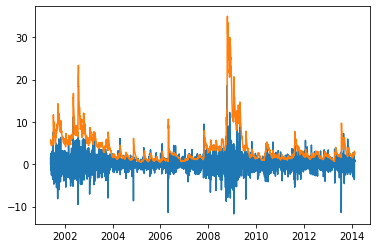

In [23]:
y1 = enriched_ret_data['return100']
y2 = enriched_ret_data['var_pred_GARCH-StudentsT-1-1']
y3 = enriched_ret_data['mean5_return100']
y4 = enriched_ret_data['var5_return100']
plt.plot(y1)
plt.plot(y2)
# plt.plot(y3)
# plt.plot(y4)
plt.show()

### Standardize the data

In [24]:
# initiate standardizer 
Standardizer_train = Standardizer(
    demean=True,
    rescale=True,
    skipna=True
)

In [26]:
# standardize all but first column where the returns are
train_data_standard = (
    enriched_ret_data
        .drop('return100', axis=1)
        .apply(
            func=Standardizer_train.perform_calc,
            axis=0,
            result_type='broadcast'
        )
        .join(enriched_ret_data[['return100']])
)

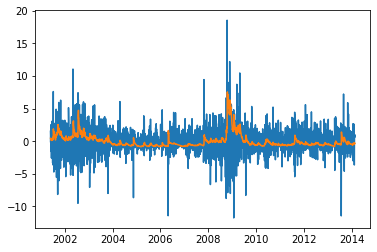

In [32]:
y1 = train_data_standard['return100']
y2 = train_data_standard['var_pred_GARCH-StudentsT-1-1']
y3 = train_data_standard['mean5_return100']
y4 = train_data_standard['var5_return100']
plt.plot(y1)
plt.plot(y2)
# plt.plot(y3)
# plt.plot(y4)

plt.show()

# Content of ANN_core - for easier manipulation here and then at the end of session copied to separate .py file

In [136]:
# =============================================================================
# define sigmoid function
# =============================================================================

def sigmoid(x):
    
    return 1/(1+ np.exp(-x))

# =============================================================================
# define sigmoid derivative function
# =============================================================================

def sigmoid_der(x):
    
#     return sigmoid(x) * (1 - sigmoid(x))
    return x * (1 - x)

# =============================================================================
# define log likelihood function
# =============================================================================

def lLik(obs_val, sigma_pred):

    LLik = -(1/2) * np.log(2 * np.pi) - (1/2) * np.log(sigma_pred ** 2) - (1/2) * ((obs_val** 2) / sigma_pred ** 2)

    return LLik	

# =============================================================================
# define derivation of log likelihood
# =============================================================================

def lLik_der(obs_val, sigma_pred):
    
    LLik_der = - 1 / sigma_pred + (1 / sigma_pred ** 3) * (obs_val ** 2)
    
    return LLik_der

# =============================================================================
# define squared errors
# =============================================================================

def square_error(obs_val, obs_pred):
    
    return (obs_val - obs_pred) ** 2

# =============================================================================
# define first derivative of squared errors
# =============================================================================
    
#in this case should be multiplied by -1 since with respect to obs_pred, but then 
#change in weights and biases is not += but -=
def square_error_der(obs_val, obs_pred):
    
    return  (obs_val - obs_pred)

# =============================================================================
# define linear function for case when only one layer
# =============================================================================
def linear(x):
    
    return x

# =============================================================================
# define derivative of linear 
# =============================================================================
def linear_der(x):
        
    return np.ones(x.shape)
# =============================================================================
# class object NeuralNetwork
# =============================================================================
    
class NeuralNetwork:

    def __init__(self, x, y, obj_fun = square_error, node_fun = linear,
                 hidden_layer = 1, step_rate = 0.001, bias = False, num_nodes = [1,0]):
        
        self.nodes1     = num_nodes[0]
        
        self.nodes2     = num_nodes[1]
        
        if obj_fun == square_error :
            
            self.obj_fun = square_error
            
            self.obj_fun_der = square_error_der
        
        elif obj_fun == lLik :
            
            self.obj_fun = lLik
            
            self.obj_fun_der = lLik_der
            
        else :
            
            print('set objective function to either squared errors or log-likelihood')
        
        self.input      = x
        
        self.y          = y

        self.output     = np.ones(self.y.shape)
        
        self.step_rate = step_rate
        
        self.bias = bias * 1
        
        if hidden_layer == 0 :
            
            self.weights_out = self.weights_hidden = np.ones([1,1])
            
            self.weights_input = np.random.rand(self.input.shape[1], 1)
            
            self.bias_out = self.bias_hidden = self.bias_input = np.zeros([1,1])
            
            self.node1_fun = linear
            
            self.node1_fun_der = linear_der
            
            self.node2_fun = linear
            
            self.node2_fun_der = linear_der
        
        elif hidden_layer == 1 :
            
            self.weights_out = np.ones([1,1])
            
            self.weights_hidden = np.random.rand(self.nodes1, 1)
            
            self.weights_input = np.random.rand(self.input.shape[1], self.nodes1)
            
            self.bias_out = self.bias_hidden = np.zeros([1,1])
            
            self.bias_input = np.zeros([1, self.nodes1])
            
            self.node1_fun = node_fun
            
            if node_fun == linear :
                
                self.node1_fun_der = linear_der
                
            elif node_fun == sigmoid :
                
                self.node1_fun_der = sigmoid_der
            
            self.node2_fun = linear
            
            self.node2_fun_der = linear_der
            
        elif hidden_layer == 2 :
            
            self.weights_out = np.random.rand(self.nodes2, 1)
            
            self.weights_hidden = np.random.rand(self.nodes1, self.nodes2)
            
            self.weights_input = np.random.rand(self.input.shape[1], self.nodes1)
            
            self.bias_out = np.zeros([1,1])
            
            self.bias_hidden = np.zeros([1, self.nodes2])
            
            self.bias_input = np.zeros([1, self.nodes1])
            
            self.node1_fun = self.node2_fun = node_fun
            
            if node_fun == linear :
                
                self.node1_fun_der = self.node2_fun_der = linear_der
                
            elif node_fun == sigmoid :
                
                self.node1_fun_der = self.node2_fun_der = sigmoid_der
                
            else:
                
                print('set the node function to either sigmoid or linear')
                
        else:
            
            print('set number of hidden layers to 0, 1 or 2')
            
    def feedforward(self):

        self.layer1 = self.node1_fun(np.dot(self.input, self.weights_input) + self.bias_input)
        
        self.layer2 = self.node2_fun(np.dot(self.layer1, self.weights_hidden) + self.bias_hidden)
        
        self.output = np.dot(self.layer2, self.weights_out) + self.bias_out
        
    def backprop(self):
        
        #calculate errors and partial derivatives
        
        error_out = self.obj_fun_der(self.y, self.output)
        
#         print(error_out.head())
        
        d_weights_out = np.dot(self.layer2.T, error_out) 
        
#         print(d_weights_out)
        
        error_hidden = np.dot(error_out, self.weights_out.T) * self.node2_fun_der(self.layer2) # this is derivative in terms of f(x) maybe should change to derivative in terms of x, then it needs to be layer1*weights_hidden
        
#         print(error_hidden[1:5])
        
        d_weights_hidden = np.dot(self.layer1.T, error_hidden) 
        
#         print(d_weights_hidden)
        
        error_input = np.dot(error_hidden, self.weights_hidden.T) * self.node1_fun_der(self.layer1)
        
#         print(error_input[1:5])
        
        d_weights_input = np.dot(self.input.T, error_input)
        
#         print(d_weights_input)
        
        d_bias_out = np.dot(np.ones(self.output.shape[0]), error_out) 
        
        d_bias_hidden = np.dot(np.ones(self.layer2.shape[0]), error_hidden)
        
        d_bias_input = np.dot(np.ones(self.input.shape[0]), error_input)
        
        #update weights and biases
        
        self.weights_out += d_weights_out * self.step_rate * (self.nodes2 > 0)
        
        self.weights_hidden += d_weights_hidden * self.step_rate * (self.nodes1 > 0) 
        
        self.weights_input += d_weights_input * self.step_rate
        
        self.bias_out += d_bias_out * self.step_rate * self.bias * (self.nodes2 > 0)
        
        self.bias_hidden += d_bias_hidden * self.step_rate * self.bias * (self.nodes1 > 0)
        
        self.bias_input += d_bias_input * self.step_rate * self.bias
    
    def cost(self, new_input = None, new_y = None):
        # check if different input specified
        if new_input is None and new_y is None: 
            # if not - get the cost from training
            return np.sum(self.obj_fun(self.y, self.output))
        else:
            # if yes - get new prediction 
            temp_layer1 = self.node1_fun(np.dot(new_input, self.weights_input) + self.bias_input)
            temp_layer2 = self.node2_fun(np.dot(temp_layer1, self.weights_hidden) + self.bias_hidden)
            temp_output = np.dot(temp_layer2, self.weights_out) + self.bias_out

            return np.sum(self.obj_fun(new_y, temp_output))
    
    def predict(self, new_input = None):
        # check if different input specified
        if new_input is None: 
            # if not - get the output from training
            return self.output
        else:
            # if yes - get new prediction 
            temp_layer1 = self.node1_fun(np.dot(new_input, self.weights_input) + self.bias_input)
            temp_layer2 = self.node2_fun(np.dot(temp_layer1, self.weights_hidden) + self.bias_hidden)
            temp_output = np.dot(temp_layer2, self.weights_out) + self.bias_out

            return temp_output
        
    def add_data(self, new_x, new_y):
     
        self.input = pd.concat([self.input, new_x])
        
        self.y = pd.concat([self.y, new_y])       
    
    # this has been here for debugging
    def get_weights(self):
        return [self.weights_input, self.weights_hidden, self.weights_out]


### ANN Estimation

In [145]:
NN_obj = NeuralNetwork(
    x=train_data_standard.drop('return100', axis=1),
    y=train_data_standard[['return100']],
    obj_fun=lLik,
    hidden_layer=2,
    node_fun=sigmoid,
    num_nodes=[10,10],
    step_rate=0.001
)

In [146]:
NN_obj.feedforward()
for i in range(5000):
        NN_obj.backprop()
        NN_obj.feedforward()
        print(i)
        print(NN_obj.cost()[0])

0
-11182.473890896295
1
-18937.01660719198
2
-18900.80135483254
3
-18863.232980713692
4
-18824.246860479347
5
-18783.718933087126
6
-18741.447281041605
7
-18697.13462547789
8
-18650.378819835976
9
-18600.686636715458
10
-18547.534763422125
11
-18490.493156626715
12
-18429.36918648907
13
-18364.258277557565
14
-18295.48290796692
15
-18223.682822549075
16
-18150.192494069895
17
-18077.107852865774
18
-18006.40059624736
19
-17938.74983516283
20
-17873.249843828402
21
-17807.87885458429
22
-17739.970394854754
23
-17666.49696149089
24
-17584.589543288283
25
-17492.96138179699
26
-17393.921079836982
27
-17292.770480498468
28
-17192.72978075744
29
-17091.217899787633
30
-16980.485012019453
31
-16848.270352962914
32
-16677.470281139067
33
-16451.7212992723
34
-16177.599593972867
35
-15900.875461370346
36
-15657.616296295972
37
-15428.012215170736
38
-15163.020968967976
39
-14767.265445159905
40
-13957.772489372324
41
-12452.358555160443
42
-11990.053395082141
43
-11860.41365874782
44
-10087.35

-6067.2878641496145
374
-6061.694525268266
375
-6067.134842821068
376
-6061.567097092979
377
-6066.982571775408
378
-6061.440397894595
379
-6066.831051512166
380
-6061.314425476746
381
-6066.680281912177
382
-6061.189177146531
383
-6066.530262287717
384
-6061.0646497539465
385
-6066.3809914312915
386
-6060.940839730363
387
-6066.2324676628805
388
-6060.817743125862
389
-6066.084688875443
390
-6060.6953556453345
391
-6065.937652578543
392
-6060.573672683197
393
-6065.791355939948
394
-6060.452689356653
395
-6065.6457958251385
396
-6060.332400537426
397
-6065.50096883464
398
-6060.212800881911
399
-6065.356871339133
400
-6060.09388485971
401
-6065.213499512343
402
-6059.975646780533
403
-6065.070849361689
404
-6059.858080819473
405
-6064.928916756728
406
-6059.74118104063
407
-6064.787697455407
408
-6059.62494141916
409
-6064.64718712821
410
-6059.509355861715
411
-6064.507381380216
412
-6059.394418225372
413
-6064.368275771174
414
-6059.280122335047
415
-6064.229865833659
416
-6059.1664

745
-6048.6409684669015
746
-6046.254595943556
747
-6048.579470214447
748
-6046.201492357643
749
-6048.518255015798
750
-6046.148608214583
751
-6048.45732124114
752
-6046.095942408642
753
-6048.396667272475
754
-6046.043493841231
755
-6048.3362915035705
756
-6045.9912614208715
757
-6048.276192339932
758
-6045.939244063168
759
-6048.216368198748
760
-6045.887440690778
761
-6048.156817508857
762
-6045.83585023338
763
-6048.097538710701
764
-6045.784471627641
765
-6048.038530256278
766
-6045.733303817193
767
-6047.979790609096
768
-6045.682345752592
769
-6047.921318244132
770
-6045.631596391298
771
-6047.863111647774
772
-6045.5810546976445
773
-6047.80516931778
774
-6045.530719642801
775
-6047.747489763234
776
-6045.48059020475
777
-6047.6900715044785
778
-6045.430665368258
779
-6047.632913073079
780
-6045.3809441248395
781
-6047.576013011771
782
-6045.331425472738
783
-6047.519369874401
784
-6045.28210841689
785
-6047.462982225881
786
-6045.232991968896
787
-6047.4068486421365
788
-6045

1112
-6039.364365066874
1113
-6040.895334853635
1114
-6039.339204978362
1115
-6040.868524717471
1116
-6039.314163032079
1117
-6040.841856870467
1118
-6039.28923924963
1119
-6040.815331367003
1120
-6039.2644336601825
1121
-6040.7889482717355
1122
-6039.239746300436
1123
-6040.762707659584
1124
-6039.215177214603
1125
-6040.736609615712
1126
-6039.19072645437
1127
-6040.7106542354995
1128
-6039.166394078868
1129
-6040.684841624503
1130
-6039.142180154617
1131
-6040.659171898416
1132
-6039.118084755477
1133
-6040.633645183005
1134
-6039.094107962574
1135
-6040.608261614049
1136
-6039.070249864237
1137
-6040.583021337254
1138
-6039.046510555898
1139
-6040.557924508164
1140
-6039.0228901400105
1141
-6040.532971292057
1142
-6038.999388725926
1143
-6040.50816186382
1144
-6038.976006429782
1145
-6040.483496407819
1146
-6038.952743374359
1147
-6040.458975117741
1148
-6038.929599688936
1149
-6040.434598196426
1150
-6038.906575509117
1151
-6040.410365855678
1152
-6038.883670976651
1153
-6040.3862

1454
-6035.996270684118
1455
-6037.4666494965695
1456
-6035.965939412772
1457
-6037.433701948919
1458
-6035.93543536705
1459
-6037.400537535137
1460
-6035.904769804385
1461
-6037.367169745637
1462
-6035.873953886565
1463
-6037.333611955961
1464
-6035.84299864718
1465
-6037.299877388006
1466
-6035.811914961518
1467
-6037.26597907422
1468
-6035.7807135189605
1469
-6037.2319298248285
1470
-6035.749404797949
1471
-6037.19774219816
1472
-6035.717999043511
1473
-6037.163428474052
1474
-6035.686506247348
1475
-6037.1290006303425
1476
-6035.654936130459
1477
-6037.094470322376
1478
-6035.623298128215
1479
-6037.059848865465
1480
-6035.5916013778515
1481
-6037.0251472202035
1482
-6035.559854708241
1483
-6036.990375980525
1484
-6035.528066631878
1485
-6036.955545364363
1486
-6035.496245338938
1487
-6036.920665206788
1488
-6035.464398693296
1489
-6036.885744955431
1490
-6035.4325342303555
1491
-6036.850793668088
1492
-6035.400659156567
1493
-6036.815820012278
1494
-6035.368780350483
1495
-6036.78

1803
-6032.286394458779
1804
-6031.240324770412
1805
-6032.26252317196
1806
-6031.218339358842
1807
-6032.238701372844
1808
-6031.196396657317
1809
-6032.214928763602
1810
-6031.174496412548
1811
-6032.191205048208
1812
-6031.152638372818
1813
-6032.1675299324215
1814
-6031.130822287958
1815
-6032.14390312377
1816
-6031.109047909332
1817
-6032.120324331536
1818
-6031.087314989826
1819
-6032.0967932667445
1820
-6031.065623283834
1821
-6032.0733096421445
1822
-6031.043972547239
1823
-6032.049873172199
1824
-6031.022362537407
1825
-6032.0264835730695
1826
-6031.00079301317
1827
-6032.003140562605
1828
-6030.979263734809
1829
-6031.979843860324
1830
-6030.957774464054
1831
-6031.956593187411
1832
-6030.936324964056
1833
-6031.933388266697
1834
-6030.914914999392
1835
-6031.910228822653
1836
-6030.89354433604
1837
-6031.887114581372
1838
-6030.872212741373
1839
-6031.864045270565
1840
-6030.850919984154
1841
-6031.841020619545
1842
-6030.829665834513
1843
-6031.818040359219
1844
-6030.80845

-6027.93728190844
2147
-6028.711820210139
2148
-6027.919897503709
2149
-6028.693252644613
2150
-6027.90252862244
2151
-6028.674702583896
2152
-6027.885175174584
2153
-6028.656169924565
2154
-6027.867837070653
2155
-6028.637654563865
2156
-6027.850514221709
2157
-6028.619156399695
2158
-6027.833206539364
2159
-6028.6006753306065
2160
-6027.815913935781
2161
-6028.5822112558
2162
-6027.798636323662
2163
-6028.563764075122
2164
-6027.781373616253
2165
-6028.545333689057
2166
-6027.764125727334
2167
-6028.526919998731
2168
-6027.746892571221
2169
-6028.508522905896
2170
-6027.729674062757
2171
-6028.490142312938
2172
-6027.712470117316
2173
-6028.471778122865
2174
-6027.695280650791
2175
-6028.453430239306
2176
-6027.678105579598
2177
-6028.435098566507
2178
-6027.660944820671
2179
-6028.416783009327
2180
-6027.643798291456
2181
-6028.398483473235
2182
-6027.626665909908
2183
-6028.380199864299
2184
-6027.609547594493
2185
-6028.361932089197
2186
-6027.59244326418
2187
-6028.343680055197
2

2523
-6025.442833187588
2524
-6024.850754418843
2525
-6025.426285533044
2526
-6024.835173588531
2527
-6025.409743987097
2528
-6024.81959813574
2529
-6025.39320851755
2530
-6024.804028030985
2531
-6025.3766790924
2532
-6024.788463244933
2533
-6025.36015567982
2534
-6024.77290374841
2535
-6025.343638248169
2536
-6024.7573495123925
2537
-6025.327126765982
2538
-6024.741800508015
2539
-6025.3106212019775
2540
-6024.726256706559
2541
-6025.29412152505
2542
-6024.710718079457
2543
-6025.277627704272
2544
-6024.695184598297
2545
-6025.2611397088895
2546
-6024.679656234806
2547
-6025.244657508323
2548
-6024.664132960868
2549
-6025.228181072167
2550
-6024.648614748508
2551
-6025.211710370189
2552
-6024.6331015699
2553
-6025.195245372324
2554
-6024.617593397359
2555
-6025.178786048678
2556
-6024.602090203347
2557
-6025.162332369526
2558
-6024.586591960466
2559
-6025.14588430531
2560
-6024.571098641461
2561
-6025.129441826634
2562
-6024.555610219217
2563
-6025.113004904272
2564
-6024.540126666758

2899
-6022.411459465271
2900
-6021.990142514278
2901
-6022.39564273929
2902
-6021.975180492863
2903
-6022.379828229305
2904
-6021.960220144852
2905
-6022.36401592168
2906
-6021.945261456643
2907
-6022.3482058028185
2908
-6021.930304414658
2909
-6022.332397859158
2910
-6021.9153490053595
2911
-6022.316592077172
2912
-6021.900395215234
2913
-6022.300788443372
2914
-6021.885443030807
2915
-6022.2849869443
2916
-6021.87049243863
2917
-6022.2691875665405
2918
-6021.855543425288
2919
-6022.2533902967025
2920
-6021.840595977395
2921
-6022.237595121438
2922
-6021.825650081595
2923
-6022.221802027426
2924
-6021.810705724563
2925
-6022.206011001381
2926
-6021.795762893002
2927
-6022.190222030049
2928
-6021.780821573644
2929
-6022.174435100209
2930
-6021.76588175325
2931
-6022.158650198669
2932
-6021.75094341861
2933
-6022.142867312273
2934
-6021.736006556537
2935
-6022.12708642789
2936
-6021.721071153877
2937
-6022.111307532425
2938
-6021.706137197501
2939
-6022.095530612808
2940
-6021.691204674

3243
-6019.713039792404
3244
-6019.430688548069
3245
-6019.697420999531
3246
-6019.415829735673
3247
-6019.6818023186515
3248
-6019.400970472102
3249
-6019.666183737669
3250
-6019.386110745105
3251
-6019.650565244468
3252
-6019.371250542418
3253
-6019.634946826938
3254
-6019.356389851777
3255
-6019.619328472953
3256
-6019.341528660903
3257
-6019.603710170382
3258
-6019.326666957516
3259
-6019.588091907086
3260
-6019.311804729327
3261
-6019.572473670922
3262
-6019.296941964036
3263
-6019.556855449732
3264
-6019.282078649341
3265
-6019.541237231359
3266
-6019.267214772926
3267
-6019.525619003635
3268
-6019.252350322477
3269
-6019.510000754382
3270
-6019.237485285663
3271
-6019.494382471417
3272
-6019.22261965015
3273
-6019.478764142551
3274
-6019.207753403596
3275
-6019.463145755584
3276
-6019.192886533653
3277
-6019.44752729831
3278
-6019.178019027962
3279
-6019.431908758517
3280
-6019.163150874161
3281
-6019.416290123982
3282
-6019.148282059876
3283
-6019.400671382478
3284
-6019.133412

3584
-6016.888167900602
3585
-6017.033758864496
3586
-6016.87305303667
3587
-6017.017980015477
3588
-6016.857935621067
3589
-6017.0021991933245
3590
-6016.842815642689
3591
-6016.986416387115
3592
-6016.827693090478
3593
-6016.970631585962
3594
-6016.812567953413
3595
-6016.954844779026
3596
-6016.797440220524
3597
-6016.939055955504
3598
-6016.782309880877
3599
-6016.923265104642
3600
-6016.767176923586
3601
-6016.9074722157275
3602
-6016.752041337809
3603
-6016.891677278089
3604
-6016.736903112749
3605
-6016.875880281105
3606
-6016.7217622376575
3607
-6016.860081214196
3608
-6016.706618701831
3609
-6016.84428006683
3610
-6016.691472494615
3611
-6016.828476828521
3612
-6016.6763236054
3613
-6016.812671488833
3614
-6016.661172023631
3615
-6016.796864037374
3616
-6016.646017738798
3617
-6016.781054463804
3618
-6016.630860740444
3619
-6016.765242757832
3620
-6016.615701018163
3621
-6016.749428909216
3622
-6016.600538561601
3623
-6016.733612907766
3624
-6016.585373360453
3625
-6016.717794

-6014.165612176787
3939
-6014.2027642489265
3940
-6014.149938215463
3941
-6014.186528987575
3942
-6014.13426100942
3943
-6014.170291033295
3944
-6014.118580564998
3945
-6014.154050391551
3946
-6014.102896888673
3947
-6014.137807067931
3948
-6014.087209987054
3949
-6014.121561068139
3950
-6014.07151986688
3951
-6014.105312397999
3952
-6014.055826535028
3953
-6014.089061063456
3954
-6014.040129998505
3955
-6014.07280707057
3956
-6014.02443026445
3957
-6014.0565504255255
3958
-6014.008727340133
3959
-6014.040291134622
3960
-6013.993021232962
3961
-6014.024029204277
3962
-6013.9773119504725
3963
-6014.00776464103
3964
-6013.961599500331
3965
-6013.991497451531
3966
-6013.945883890342
3967
-6013.975227642556
3968
-6013.930165128433
3969
-6013.958955220993
3970
-6013.914443222671
3971
-6013.942680193848
3972
-6013.898718181248
3973
-6013.926402568244
3974
-6013.882990012491
3975
-6013.91012235142
3976
-6013.867258724855
3977
-6013.893839550732
3978
-6013.851524326927
3979
-6013.87755417365
3

-6011.114350791295
4316
-6011.158742862164
4317
-6011.097810756943
4318
-6011.142693733046
4319
-6011.081270555508
4320
-6011.126644378861
4321
-6011.064730203777
4322
-6011.110594820825
4323
-6011.048189718513
4324
-6011.094545080152
4325
-6011.03164911646
4326
-6011.078495178062
4327
-6011.015108414341
4328
-6011.062445135769
4329
-6010.998567628854
4330
-6011.04639497449
4331
-6010.982026776676
4332
-6011.030344715435
4333
-6010.96548587446
4334
-6011.014294379816
4335
-6010.948944938834
4336
-6010.998243988841
4337
-6010.932403986398
4338
-6010.98219356371
4339
-6010.915863033728
4340
-6010.966143125622
4341
-6010.899322097372
4342
-6010.950092695768
4343
-6010.88278119385
4344
-6010.934042295332
4345
-6010.866240339656
4346
-6010.917991945495
4347
-6010.849699551249
4348
-6010.901941667423
4349
-6010.833158845061
4350
-6010.885891482278
4351
-6010.816618237493
4352
-6010.869841411211
4353
-6010.800077744913
4354
-6010.853791475365
4355
-6010.783537383659
4356
-6010.837741695869
43

4674
-6008.30140096417
4675
-6008.148617150906
4676
-6008.285624654021
4677
-6008.132270058481
4678
-6008.269851385938
4679
-6008.1159248961485
4680
-6008.254081173195
4681
-6008.0995816679715
4682
-6008.238314029004
4683
-6008.083240377908
4684
-6008.222549966509
4685
-6008.066901029821
4686
-6008.206788998789
4687
-6008.05056362747
4688
-6008.19103113886
4689
-6008.034228174516
4690
-6008.17527639967
4691
-6008.017894674518
4692
-6008.159524794104
4693
-6008.001563130936
4694
-6008.1437763349795
4695
-6007.985233547128
4696
-6008.128031035052
4697
-6007.968905926352
4698
-6008.11228890701
4699
-6007.952580271762
4700
-6008.096549963478
4701
-6007.936256586416
4702
-6008.080814217012
4703
-6007.919934873267
4704
-6008.06508168011
4705
-6007.90361513517
4706
-6008.049352365197
4707
-6007.887297374874
4708
-6008.033626284638
4709
-6007.87098159503
4710
-6008.017903450732
4711
-6007.854667798188
4712
-6008.002183875715
4713
-6007.838355986794
4714
-6007.986467571753
4715
-6007.8220461631

### Results on Training Dataset

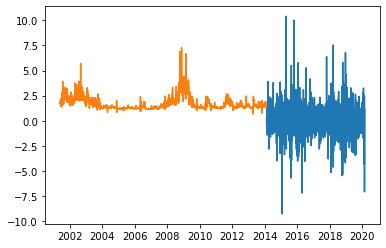

In [147]:
# Plot results
y1 = enriched_ret_data['return100']
y2 = pd.DataFrame(data=NN_obj.predict(), index = train_data_standard.index)
y3 = np.sqrt(enriched_ret_data['var_pred_EGARCH-Normal-1-1'])
plt.plot(y1)
plt.plot(y2)
# plt.plot(y3)
plt.show()

In [148]:
# Compare Log-Likelihoods
print(
    f'''
    Calculations on training dataset
    Log_likelihood of average sigma : {lLik(obs_val=enriched_ret_data[['return100']].to_numpy(), sigma_pred=np.sqrt(enriched_ret_data[['var5_return100']].to_numpy())).sum()}
    Log_likelihood of Garch prediction : {lLik(obs_val=enriched_ret_data[['return100']].to_numpy(), sigma_pred=np.sqrt(enriched_ret_data[['var_pred_GARCH-Normal-1-1']].to_numpy())).sum()} 
    Log_likelihood of NN prediction : {lLik(obs_val=enriched_ret_data[['return100']].to_numpy(), sigma_pred=NN_obj.predict()).sum()}
    '''
)

ValueError: operands could not be broadcast together with shapes (1521,1) (3195,1) 

### Results on Testing Dataset

##### ARCH

In [63]:
test_eval_merged_data = pd.concat([eval_data_garch, test_data])

In [64]:
ArchMod_test = ArchModelWrapper(train_data=test_eval_merged_data, eval_data_garch=test_data)

In [65]:
time_begin = perf_counter()
space['llik'] = best_spec.apply(lambda row: ArchMod_test.estimate_predict(row['models'], row['p'], row['q'], row['dist']),
                                    axis=1)
f'Time of calculations: {round((perf_counter()-time_begin)/60, 0)} min'

'Time of calculations: 5.0 min'

In [66]:
predictions = ArchMod_test.get_predictions()

##### prepare data for NN

In [67]:
predictions_df = pd.DataFrame(index = test_eval_merged_data.index)
for mod in best_spec_strings : 
    predictions_df = predictions_df.merge(
        predictions[mod].add_suffix(f'_{mod}'),
        left_index=True,
        right_index = True, 
    )

In [72]:
# since demeaning drop empty columns with mu
drop_cols = predictions_df.columns[predictions_df.columns.map(lambda x: x.startswith('mean'))]
predictions_df = predictions_df.drop(drop_cols, axis=1)

In [73]:
desc_obj = DescStat(data=test_data['return100'])

In [74]:
desc_data = (
    pd.DataFrame(
        {
            'mean5_return100': desc_obj.calc_mean(window=5, fill_initial='first_constant'),
            'var5_return100': desc_obj.calc_var(window=5, fill_initial='first_constant'),
            'dt': test_data.index
        }
    ).set_index('dt')
)

In [149]:
enriched_ret_data = (
    test_data
        .merge(
            desc_data,
            left_index=True,
            right_index=True
        )
        .merge(
            predictions_df,
            left_index=True,
            right_index=True
        )
)

In [150]:
# standardize all but first column where the returns are
test_data_standard = (
    enriched_ret_data
        .drop('return100', axis=1)
        .apply(
            func=Standardizer_train.predict,
            axis=0,
            result_type='broadcast'
        )
        .join(test_data[['return100']])
)

##### ANN

In [152]:
nn_predictions = np.array([])
for i in test_data_standard.index: 
    # new row
    new_row = test_data_standard.loc[[i],:].drop(['return100'], axis=1)
    # predict on it
    nn_predictions = np.append(nn_predictions, NN_obj.predict(new_input = new_row)) 
    
    print(NN_obj.input.shape)
    print(NN_obj.y.shape)
    
    NN_obj.add_data(
            new_x=test_data_standard.loc[[i],:].drop(['return100'], axis=1),
            new_y=test_data_standard.loc[[i],:][['return100']],
    )
    NN_obj.feedforward()
    for j in range(10):
        print(i,j)
        NN_obj.backprop()
        NN_obj.feedforward()
        print(NN_obj.cost()[0])


(3195, 6)
(3195, 1)
2014-02-13 00:00:00 0
-6007.2455043179425
2014-02-13 00:00:00 1
-6006.990429126929
2014-02-13 00:00:00 2
-6007.246816787367
2014-02-13 00:00:00 3
-6006.989147370605
2014-02-13 00:00:00 4
-6007.247911478047
2014-02-13 00:00:00 5
-6006.987588095045
2014-02-13 00:00:00 6
-6007.24739513747
2014-02-13 00:00:00 7
-6006.984498435608
2014-02-13 00:00:00 8
-6007.244446297862
2014-02-13 00:00:00 9
-6006.979126936334
(3196, 6)
(3196, 1)
2014-02-14 00:00:00 0
-6008.642522866943
2014-02-14 00:00:00 1
-6008.388337227687
2014-02-14 00:00:00 2
-6008.6500923023195
2014-02-14 00:00:00 3
-6008.392272291689
2014-02-14 00:00:00 4
-6008.654456942556
2014-02-14 00:00:00 5
-6008.393149100868
2014-02-14 00:00:00 6
-6008.6543794427525
2014-02-14 00:00:00 7
-6008.38986981765
2014-02-14 00:00:00 8
-6008.649299987526
2014-02-14 00:00:00 9
-6008.38193756733
(3197, 6)
(3197, 1)
2014-02-18 00:00:00 0
-6010.058493642068
2014-02-18 00:00:00 1
-6009.80168747465
2014-02-18 00:00:00 2
-6010.05970743856

-6035.530853616362
2014-03-17 00:00:00 7
-6035.345456110131
2014-03-17 00:00:00 8
-6035.512303674591
2014-03-17 00:00:00 9
-6035.324737239087
(3217, 6)
(3217, 1)
2014-03-18 00:00:00 0
-6041.051640363461
2014-03-18 00:00:00 1
-6040.862819381629
2014-03-18 00:00:00 2
-6041.102377164227
2014-03-18 00:00:00 3
-6040.918830679237
2014-03-18 00:00:00 4
-6041.141433083779
2014-03-18 00:00:00 5
-6040.956116297973
2014-03-18 00:00:00 6
-6041.16800364452
2014-03-18 00:00:00 7
-6040.97841214477
2014-03-18 00:00:00 8
-6041.183105722952
2014-03-18 00:00:00 9
-6040.988665312856
(3218, 6)
(3218, 1)
2014-03-19 00:00:00 0
-6042.684420017889
2014-03-19 00:00:00 1
-6042.500323271546
2014-03-19 00:00:00 2
-6042.6971149243445
2014-03-19 00:00:00 3
-6042.506732029785
2014-03-19 00:00:00 4
-6042.69881914653
2014-03-19 00:00:00 5
-6042.5028679569605
2014-03-19 00:00:00 6
-6042.690799768556
2014-03-19 00:00:00 7
-6042.490312083752
2014-03-19 00:00:00 8
-6042.674854033258
2014-03-19 00:00:00 9
-6042.470721276853

2014-04-16 00:00:00 0
-6079.203308905338
2014-04-16 00:00:00 1
-6079.033561382392
2014-04-16 00:00:00 2
-6079.195550805565
2014-04-16 00:00:00 3
-6079.024211510974
2014-04-16 00:00:00 4
-6079.183836661219
2014-04-16 00:00:00 5
-6079.009751242119
2014-04-16 00:00:00 6
-6079.16805372501
2014-04-16 00:00:00 7
-6078.990589767864
2014-04-16 00:00:00 8
-6079.148242688444
2014-04-16 00:00:00 9
-6078.967111773527
(3239, 6)
(3239, 1)
2014-04-17 00:00:00 0
-6080.720751186769
2014-04-17 00:00:00 1
-6080.552926774828
2014-04-17 00:00:00 2
-6080.714916572531
2014-04-17 00:00:00 3
-6080.543659551086
2014-04-17 00:00:00 4
-6080.705813790115
2014-04-17 00:00:00 5
-6080.530075134446
2014-04-17 00:00:00 6
-6080.692204903883
2014-04-17 00:00:00 7
-6080.511728597888
2014-04-17 00:00:00 8
-6080.673765174177
2014-04-17 00:00:00 9
-6080.488643448274
(3240, 6)
(3240, 1)
2014-04-21 00:00:00 0
-6082.026909040122
2014-04-21 00:00:00 1
-6081.855420974129
2014-04-21 00:00:00 2
-6082.017651107746
2014-04-21 00:00:0

-6107.9531366560295
2014-05-16 00:00:00 8
-6108.152509637379
2014-05-16 00:00:00 9
-6107.927445230363
(3260, 6)
(3260, 1)
2014-05-19 00:00:00 0
-6109.3900919865855
2014-05-19 00:00:00 1
-6109.178794567906
2014-05-19 00:00:00 2
-6109.3776174588875
2014-05-19 00:00:00 3
-6109.164245089741
2014-05-19 00:00:00 4
-6109.3622688883
2014-05-19 00:00:00 5
-6109.145617789569
2014-05-19 00:00:00 6
-6109.342870207338
2014-05-19 00:00:00 7
-6109.122348617236
2014-05-19 00:00:00 8
-6109.318964158791
2014-05-19 00:00:00 9
-6109.094341524608
(3261, 6)
(3261, 1)
2014-05-20 00:00:00 0
-6110.5165036855915
2014-05-20 00:00:00 1
-6110.3069347667315
2014-05-20 00:00:00 2
-6110.502661625664
2014-05-20 00:00:00 3
-6110.291561415456
2014-05-20 00:00:00 4
-6110.486644241426
2014-05-20 00:00:00 5
-6110.2725612752165
2014-05-20 00:00:00 6
-6110.467026841313
2014-05-20 00:00:00 7
-6110.249192915986
2014-05-20 00:00:00 8
-6110.443105944709
2014-05-20 00:00:00 9
-6110.2212075598645
(3262, 6)
(3262, 1)
2014-05-21 00:

2014-06-16 00:00:00 0
-6135.333257279478
2014-06-16 00:00:00 1
-6135.120943475383
2014-06-16 00:00:00 2
-6135.319864455589
2014-06-16 00:00:00 3
-6135.106045656867
2014-06-16 00:00:00 4
-6135.30376556765
2014-06-16 00:00:00 5
-6135.086896761428
2014-06-16 00:00:00 6
-6135.283984538382
2014-06-16 00:00:00 7
-6135.063066347344
2014-06-16 00:00:00 8
-6135.260032937062
2014-06-16 00:00:00 9
-6135.034475368915
(3280, 6)
(3280, 1)
2014-06-17 00:00:00 0
-6136.4785972386035
2014-06-17 00:00:00 1
-6136.266841892899
2014-06-17 00:00:00 2
-6136.46325464879
2014-06-17 00:00:00 3
-6136.250343760808
2014-06-17 00:00:00 4
-6136.445301625106
2014-06-17 00:00:00 5
-6136.229875190496
2014-06-17 00:00:00 6
-6136.423854901724
2014-06-17 00:00:00 7
-6136.204978135813
2014-06-17 00:00:00 8
-6136.398481080722
2014-06-17 00:00:00 9
-6136.175547465906
(3281, 6)
(3281, 1)
2014-06-18 00:00:00 0
-6137.567990812191
2014-06-18 00:00:00 1
-6137.359216164346
2014-06-18 00:00:00 2
-6137.549449331819
2014-06-18 00:00:0

-6157.716746360639
2014-07-14 00:00:00 2
-6157.787071135752
2014-07-14 00:00:00 3
-6157.704944328629
2014-07-14 00:00:00 4
-6157.769846017651
2014-07-14 00:00:00 5
-6157.688401992211
2014-07-14 00:00:00 6
-6157.7490396158
2014-07-14 00:00:00 7
-6157.666839440864
2014-07-14 00:00:00 8
-6157.724400552484
2014-07-14 00:00:00 9
-6157.640118521065
(3299, 6)
(3299, 1)
2014-07-15 00:00:00 0
-6158.999299568799
2014-07-15 00:00:00 1
-6158.931848667273
2014-07-15 00:00:00 2
-6158.986387790769
2014-07-15 00:00:00 3
-6158.920300485399
2014-07-15 00:00:00 4
-6158.97007020651
2014-07-15 00:00:00 5
-6158.903730004931
2014-07-15 00:00:00 6
-6158.949906069784
2014-07-15 00:00:00 7
-6158.881806100084
2014-07-15 00:00:00 8
-6158.925567501961
2014-07-15 00:00:00 9
-6158.854396258642
(3300, 6)
(3300, 1)
2014-07-16 00:00:00 0
-6164.770385610165
2014-07-16 00:00:00 1
-6164.686532769718
2014-07-16 00:00:00 2
-6164.88395235721
2014-07-16 00:00:00 3
-6164.771689920393
2014-07-16 00:00:00 4
-6164.976079238902
20

-6186.167571738358
2014-08-08 00:00:00 8
-6185.970266853106
2014-08-08 00:00:00 9
-6186.131312016265
(3318, 6)
(3318, 1)
2014-08-11 00:00:00 0
-6187.09762008166
2014-08-11 00:00:00 1
-6187.278879473139
2014-08-11 00:00:00 2
-6187.073308058348
2014-08-11 00:00:00 3
-6187.256717186914
2014-08-11 00:00:00 4
-6187.045946774304
2014-08-11 00:00:00 5
-6187.229581805312
2014-08-11 00:00:00 6
-6187.0149491983275
2014-08-11 00:00:00 7
-6187.196993070421
2014-08-11 00:00:00 8
-6186.980018687218
2014-08-11 00:00:00 9
-6187.15879567729
(3319, 6)
(3319, 1)
2014-08-12 00:00:00 0
-6188.245085238412
2014-08-12 00:00:00 1
-6188.442687269018
2014-08-12 00:00:00 2
-6188.225422607813
2014-08-12 00:00:00 3
-6188.42395339472
2014-08-12 00:00:00 4
-6188.202587558282
2014-08-12 00:00:00 5
-6188.4000523585455
2014-08-12 00:00:00 6
-6188.175754509744
2014-08-12 00:00:00 7
-6188.370410368928
2014-08-12 00:00:00 8
-6188.144501255152
2014-08-12 00:00:00 9
-6188.334828768855
(3320, 6)
(3320, 1)
2014-08-13 00:00:00 

-6212.635656731714
2014-09-10 00:00:00 4
-6212.199515243052
2014-09-10 00:00:00 5
-6212.584340426566
2014-09-10 00:00:00 6
-6212.147373676067
2014-09-10 00:00:00 7
-6212.525267329174
2014-09-10 00:00:00 8
-6212.090594961497
2014-09-10 00:00:00 9
-6212.459369803731
(3340, 6)
(3340, 1)
2014-09-11 00:00:00 0
-6213.1788306855915
2014-09-11 00:00:00 1
-6213.56227067741
2014-09-11 00:00:00 2
-6213.130259845137
2014-09-11 00:00:00 3
-6213.506582426826
2014-09-11 00:00:00 4
-6213.074902772404
2014-09-11 00:00:00 5
-6213.442564083576
2014-09-11 00:00:00 6
-6213.014714293602
2014-09-11 00:00:00 7
-6213.371569663206
2014-09-11 00:00:00 8
-6212.950983717709
2014-09-11 00:00:00 9
-6213.294563085517
(3341, 6)
(3341, 1)
2014-09-12 00:00:00 0
-6214.1618798907275
2014-09-12 00:00:00 1
-6214.513762765329
2014-09-12 00:00:00 2
-6214.112817098229
2014-09-12 00:00:00 3
-6214.452821000584
2014-09-12 00:00:00 4
-6214.058694300719
2014-09-12 00:00:00 5
-6214.384813690038
2014-09-12 00:00:00 6
-6214.0006063874

-6248.1032609810545
2014-10-09 00:00:00 2
-6245.6073886079585
2014-10-09 00:00:00 3
-6248.107885495123
2014-10-09 00:00:00 4
-6245.556969607244
2014-10-09 00:00:00 5
-6248.066996983074
2014-10-09 00:00:00 6
-6245.478331582546
2014-10-09 00:00:00 7
-6247.98457617379
2014-10-09 00:00:00 8
-6245.37486656703
2014-10-09 00:00:00 9
-6247.864674237849
(3361, 6)
(3361, 1)
2014-10-10 00:00:00 0
-6250.7718019351605
2014-10-10 00:00:00 1
-6253.1455907556665
2014-10-10 00:00:00 2
-6250.714248240003
2014-10-10 00:00:00 3
-6253.045696180111
2014-10-10 00:00:00 4
-6250.614349267413
2014-10-10 00:00:00 5
-6252.895500944731
2014-10-10 00:00:00 6
-6250.492356249257
2014-10-10 00:00:00 7
-6252.712986888511
2014-10-10 00:00:00 8
-6250.359597055047
2014-10-10 00:00:00 9
-6252.508553993675
(3362, 6)
(3362, 1)
2014-10-13 00:00:00 0
-6251.805081309096
2014-10-13 00:00:00 1
-6253.900219635278
2014-10-13 00:00:00 2
-6251.695368207786
2014-10-13 00:00:00 3
-6253.69736962757
2014-10-13 00:00:00 4
-6251.5911904370

-6280.097132089073
2014-11-10 00:00:00 3
-6277.724997815338
2014-11-10 00:00:00 4
-6280.084444234239
2014-11-10 00:00:00 5
-6277.718105588058
2014-11-10 00:00:00 6
-6280.073671247913
2014-11-10 00:00:00 7
-6277.713341652641
2014-11-10 00:00:00 8
-6280.065319076587
2014-11-10 00:00:00 9
-6277.710929781542
(3383, 6)
(3383, 1)
2014-11-11 00:00:00 0
-6281.249584222799
2014-11-11 00:00:00 1
-6278.898693014531
2014-11-11 00:00:00 2
-6281.2422502757845
2014-11-11 00:00:00 3
-6278.8993352891175
2014-11-11 00:00:00 4
-6281.236922522068
2014-11-11 00:00:00 5
-6278.902724432819
2014-11-11 00:00:00 6
-6281.234381786571
2014-11-11 00:00:00 7
-6278.909271208198
2014-11-11 00:00:00 8
-6281.234856838624
2014-11-11 00:00:00 9
-6278.9191767410975
(3384, 6)
(3384, 1)
2014-11-12 00:00:00 0
-6282.425973562858
2014-11-12 00:00:00 1
-6280.118368900596
2014-11-12 00:00:00 2
-6282.428871719827
2014-11-12 00:00:00 3
-6280.134744113248
2014-11-12 00:00:00 4
-6282.4350076560095
2014-11-12 00:00:00 5
-6280.1558610

-6338.675945336294
2014-12-11 00:00:00 5
-6331.587553472051
2014-12-11 00:00:00 6
-6341.28976781259
2014-12-11 00:00:00 7
-6333.1045796489325
2014-12-11 00:00:00 8
-6342.851837516739
2014-12-11 00:00:00 9
-6333.767957873277
(3405, 6)
(3405, 1)
2014-12-12 00:00:00 0
-6344.389933139054
2014-12-12 00:00:00 1
-6334.806865187306
2014-12-12 00:00:00 2
-6343.742105289717
2014-12-12 00:00:00 3
-6333.989295844627
2014-12-12 00:00:00 4
-6342.204205086055
2014-12-12 00:00:00 5
-6332.63961819461
2014-12-12 00:00:00 6
-6340.039546357308
2014-12-12 00:00:00 7
-6330.945324882479
2014-12-12 00:00:00 8
-6337.517108943414
2014-12-12 00:00:00 9
-6329.073798068919
(3406, 6)
(3406, 1)
2014-12-15 00:00:00 0
-6336.072507068819
2014-12-15 00:00:00 1
-6328.406403733934
2014-12-15 00:00:00 2
-6333.51301858809
2014-12-15 00:00:00 3
-6326.579322948005
2014-12-15 00:00:00 4
-6331.0801563102905
2014-12-15 00:00:00 5
-6324.845085753478
2014-12-15 00:00:00 6
-6328.827848869345
2014-12-15 00:00:00 7
-6323.234586373429

-6357.024120382992
2015-01-14 00:00:00 3
-6357.69997892122
2015-01-14 00:00:00 4
-6356.960229113307
2015-01-14 00:00:00 5
-6357.5997504672305
2015-01-14 00:00:00 6
-6356.894254410654
2015-01-14 00:00:00 7
-6357.499283284016
2015-01-14 00:00:00 8
-6356.826592775175
2015-01-14 00:00:00 9
-6357.399013918572
(3427, 6)
(3427, 1)
2015-01-15 00:00:00 0
-6358.401553081815
2015-01-15 00:00:00 1
-6358.973893764563
2015-01-15 00:00:00 2
-6358.3648365116815
2015-01-15 00:00:00 3
-6358.916058848903
2015-01-15 00:00:00 4
-6358.3270475370755
2015-01-15 00:00:00 5
-6358.85708675801
2015-01-15 00:00:00 6
-6358.286360330971
2015-01-15 00:00:00 7
-6358.796160572616
2015-01-15 00:00:00 8
-6358.242667777967
2015-01-15 00:00:00 9
-6358.733409529765
(3428, 6)
(3428, 1)
2015-01-16 00:00:00 0
-6360.131184058651
2015-01-16 00:00:00 1
-6360.633153388715
2015-01-16 00:00:00 2
-6360.124827326366
2015-01-16 00:00:00 3
-6360.618543995486
2015-01-16 00:00:00 4
-6360.112985730731
2015-01-16 00:00:00 5
-6360.5997095430

-6435.1033232094
2015-02-11 00:00:00 9
-6425.042892808431
(3446, 6)
(3446, 1)
2015-02-12 00:00:00 0
-6434.013921803969
2015-02-12 00:00:00 1
-6424.955151964464
2015-02-12 00:00:00 2
-6431.262841035242
2015-02-12 00:00:00 3
-6423.065968113555
2015-02-12 00:00:00 4
-6428.736873260345
2015-02-12 00:00:00 5
-6421.323821639136
2015-02-12 00:00:00 6
-6426.460267110058
2015-02-12 00:00:00 7
-6419.740284753721
2015-02-12 00:00:00 8
-6424.434290793874
2015-02-12 00:00:00 9
-6418.315291610549
(3447, 6)
(3447, 1)
2015-02-13 00:00:00 0
-6424.6621711703765
2015-02-13 00:00:00 1
-6419.07769303595
2015-02-13 00:00:00 2
-6423.149617576636
2015-02-13 00:00:00 3
-6417.9780078831445
2015-02-13 00:00:00 4
-6421.821964443806
2015-02-13 00:00:00 5
-6416.9981064464855
2015-02-13 00:00:00 6
-6420.66170282367
2015-02-13 00:00:00 7
-6416.127045378222
2015-02-13 00:00:00 8
-6419.650441052668
2015-02-13 00:00:00 9
-6415.353446755804
(3448, 6)
(3448, 1)
2015-02-17 00:00:00 0
-6420.286838252991
2015-02-17 00:00:00 

-6443.561801953829
(3465, 6)
(3465, 1)
2015-03-12 00:00:00 0
-6444.677335569282
2015-03-12 00:00:00 1
-6445.653256473497
2015-03-12 00:00:00 2
-6444.4356819930845
2015-03-12 00:00:00 3
-6445.242570382237
2015-03-12 00:00:00 4
-6444.1887658935775
2015-03-12 00:00:00 5
-6444.834202702814
2015-03-12 00:00:00 6
-6443.943459220716
2015-03-12 00:00:00 7
-6444.4313623990765
2015-03-12 00:00:00 8
-6443.701675938593
2015-03-12 00:00:00 9
-6444.034906309854
(3466, 6)
(3466, 1)
2015-03-13 00:00:00 0
-6445.137431437662
2015-03-13 00:00:00 1
-6445.3566031814535
2015-03-13 00:00:00 2
-6444.934342756001
2015-03-13 00:00:00 3
-6445.007162435512
2015-03-13 00:00:00 4
-6444.726527526478
2015-03-13 00:00:00 5
-6444.65466339524
2015-03-13 00:00:00 6
-6444.513615322008
2015-03-13 00:00:00 7
-6444.300634918845
2015-03-13 00:00:00 8
-6444.297557909049
2015-03-13 00:00:00 9
-6443.947040176314
(3467, 6)
(3467, 1)
2015-03-16 00:00:00 0
-6445.499719524335
2015-03-16 00:00:00 1
-6445.04691977091
2015-03-16 00:00:

-6469.395057977039
2015-04-13 00:00:00 8
-6472.54220044099
2015-04-13 00:00:00 9
-6469.270817578588
(3487, 6)
(3487, 1)
2015-04-14 00:00:00 0
-6473.53929690401
2015-04-14 00:00:00 1
-6470.266529329972
2015-04-14 00:00:00 2
-6473.4105724808605
2015-04-14 00:00:00 3
-6470.143703264431
2015-04-14 00:00:00 4
-6473.286622573643
2015-04-14 00:00:00 5
-6470.023663143959
2015-04-14 00:00:00 6
-6473.167302828186
2015-04-14 00:00:00 7
-6469.906120970741
2015-04-14 00:00:00 8
-6473.052004366564
2015-04-14 00:00:00 9
-6469.790666150451
(3488, 6)
(3488, 1)
2015-04-15 00:00:00 0
-6474.754298958958
2015-04-15 00:00:00 1
-6471.494739450165
2015-04-15 00:00:00 2
-6474.649285868573
2015-04-15 00:00:00 3
-6471.385198234486
2015-04-15 00:00:00 4
-6474.545474145261
2015-04-15 00:00:00 5
-6471.276286599066
2015-04-15 00:00:00 6
-6474.442849110551
2015-04-15 00:00:00 7
-6471.16817753133
2015-04-15 00:00:00 8
-6474.341664246462
2015-04-15 00:00:00 9
-6471.061248766481
(3489, 6)
(3489, 1)
2015-04-16 00:00:00 0

-6545.034574888432
2015-05-13 00:00:00 3
-6542.034854766407
2015-05-13 00:00:00 4
-6544.8677881181975
2015-05-13 00:00:00 5
-6541.773380829991
2015-05-13 00:00:00 6
-6544.694573583865
2015-05-13 00:00:00 7
-6541.509515692773
2015-05-13 00:00:00 8
-6544.520152104306
2015-05-13 00:00:00 9
-6541.24512153356
(3509, 6)
(3509, 1)
2015-05-14 00:00:00 0
-6546.834345690731
2015-05-14 00:00:00 1
-6543.4306213720465
2015-05-14 00:00:00 2
-6546.621234248856
2015-05-14 00:00:00 3
-6543.140900768282
2015-05-14 00:00:00 4
-6546.420928430143
2015-05-14 00:00:00 5
-6542.856916726035
2015-05-14 00:00:00 6
-6546.229905553929
2015-05-14 00:00:00 7
-6542.57807167467
2015-05-14 00:00:00 8
-6546.0490165767515
2015-05-14 00:00:00 9
-6542.305153826452
(3510, 6)
(3510, 1)
2015-05-15 00:00:00 0
-6547.297231917431
2015-05-15 00:00:00 1
-6543.468756348668
2015-05-15 00:00:00 2
-6547.154789020176
2015-05-15 00:00:00 3
-6543.219649935427
2015-05-15 00:00:00 4
-6547.023992857842
2015-05-15 00:00:00 5
-6542.9799069911

-6600.921150263286
2015-06-11 00:00:00 1
-6615.291904079401
2015-06-11 00:00:00 2
-6599.946370636055
2015-06-11 00:00:00 3
-6614.016333714999
2015-06-11 00:00:00 4
-6598.571056254732
2015-06-11 00:00:00 5
-6612.075026588121
2015-06-11 00:00:00 6
-6596.973992026648
2015-06-11 00:00:00 7
-6609.765288387566
2015-06-11 00:00:00 8
-6595.2887218047235
2015-06-11 00:00:00 9
-6607.305880976557
(3529, 6)
(3529, 1)
2015-06-12 00:00:00 0
-6595.225155827214
2015-06-12 00:00:00 1
-6606.578119874803
2015-06-12 00:00:00 2
-6593.679325083995
2015-06-12 00:00:00 3
-6604.312143469671
2015-06-12 00:00:00 4
-6592.20230189213
2015-06-12 00:00:00 5
-6602.147850358413
2015-06-12 00:00:00 6
-6590.813213737958
2015-06-12 00:00:00 7
-6600.117027425615
2015-06-12 00:00:00 8
-6589.521541748111
2015-06-12 00:00:00 9
-6598.2345441876505
(3530, 6)
(3530, 1)
2015-06-15 00:00:00 0
-6589.9692923819875
2015-06-15 00:00:00 1
-6598.235212000904
2015-06-15 00:00:00 2
-6588.9480774602725
2015-06-15 00:00:00 3
-6596.75169282

-6598.47431246401
2015-07-09 00:00:00 7
-6601.80610967941
2015-07-09 00:00:00 8
-6598.378339542716
2015-07-09 00:00:00 9
-6601.680833589946
(3548, 6)
(3548, 1)
2015-07-10 00:00:00 0
-6599.512010005253
2015-07-10 00:00:00 1
-6602.840758001865
2015-07-10 00:00:00 2
-6599.444089834957
2015-07-10 00:00:00 3
-6602.7568413549725
2015-07-10 00:00:00 4
-6599.370305827797
2015-07-10 00:00:00 5
-6602.662751270838
2015-07-10 00:00:00 6
-6599.289224549977
2015-07-10 00:00:00 7
-6602.557706571717
2015-07-10 00:00:00 8
-6599.200704478477
2015-07-10 00:00:00 9
-6602.442029190883
(3549, 6)
(3549, 1)
2015-07-13 00:00:00 0
-6601.549896082306
2015-07-13 00:00:00 1
-6604.777377582813
2015-07-13 00:00:00 2
-6601.516972109441
2015-07-13 00:00:00 3
-6604.720122938535
2015-07-13 00:00:00 4
-6601.464972910393
2015-07-13 00:00:00 5
-6604.640642548347
2015-07-13 00:00:00 6
-6601.397730276547
2015-07-13 00:00:00 7
-6604.543036846893
2015-07-13 00:00:00 8
-6601.3179067952005
2015-07-13 00:00:00 9
-6604.43026807496

-6632.8304204062715
(3567, 6)
(3567, 1)
2015-08-06 00:00:00 0
-6630.32356637476
2015-08-06 00:00:00 1
-6635.380024967049
2015-08-06 00:00:00 2
-6630.45773030654
2015-08-06 00:00:00 3
-6635.609845876048
2015-08-06 00:00:00 4
-6630.710938885205
2015-08-06 00:00:00 5
-6636.001640579325
2015-08-06 00:00:00 6
-6631.168829420842
2015-08-06 00:00:00 7
-6636.680146619206
2015-08-06 00:00:00 8
-6631.973602498833
2015-08-06 00:00:00 9
-6637.865988074416
(3568, 6)
(3568, 1)
2015-08-07 00:00:00 0
-6634.6170135087195
2015-08-07 00:00:00 1
-6641.2751134258215
2015-08-07 00:00:00 2
-6636.94058762726
2015-08-07 00:00:00 3
-6644.893096391541
2015-08-07 00:00:00 4
-6640.499464333721
2015-08-07 00:00:00 5
-6650.688020920409
2015-08-07 00:00:00 6
-6645.347950738356
2015-08-07 00:00:00 7
-6658.891416957387
2015-08-07 00:00:00 8
-6650.71393401621
2015-08-07 00:00:00 9
-6668.076228476417
(3569, 6)
(3569, 1)
2015-08-10 00:00:00 0
-6656.634180004125
2015-08-10 00:00:00 1
-6676.723833243207
2015-08-10 00:00:00 

-6685.433117367384
2015-09-03 00:00:00 8
-6680.531014045451
2015-09-03 00:00:00 9
-6685.3238877569
(3588, 6)
(3588, 1)
2015-09-04 00:00:00 0
-6682.578224237615
2015-09-04 00:00:00 1
-6687.400502237859
2015-09-04 00:00:00 2
-6682.475203397957
2015-09-04 00:00:00 3
-6687.330463569708
2015-09-04 00:00:00 4
-6682.373743937691
2015-09-04 00:00:00 5
-6687.288314032202
2015-09-04 00:00:00 6
-6682.289738881251
2015-09-04 00:00:00 7
-6687.305648010106
2015-09-04 00:00:00 8
-6682.249024831156
2015-09-04 00:00:00 9
-6687.4317805787505
(3589, 6)
(3589, 1)
2015-09-08 00:00:00 0
-6684.805894758507
2015-09-08 00:00:00 1
-6690.258217988849
2015-09-08 00:00:00 2
-6685.017905034765
2015-09-08 00:00:00 3
-6690.88322715371
2015-09-08 00:00:00 4
-6685.521686809041
2015-09-08 00:00:00 5
-6692.018335988115
2015-09-08 00:00:00 6
-6686.557243962639
2015-09-08 00:00:00 7
-6693.976978540906
2015-09-08 00:00:00 8
-6688.526057889404
2015-09-08 00:00:00 9
-6697.172006360876
(3590, 6)
(3590, 1)
2015-09-09 00:00:00 0

-6714.99319600265
2015-10-02 00:00:00 2
-6712.0733929606995
2015-10-02 00:00:00 3
-6715.049740358212
2015-10-02 00:00:00 4
-6712.066462599665
2015-10-02 00:00:00 5
-6715.099385385471
2015-10-02 00:00:00 6
-6712.053934474126
2015-10-02 00:00:00 7
-6715.143118711508
2015-10-02 00:00:00 8
-6712.036611886344
2015-10-02 00:00:00 9
-6715.18177586554
(3608, 6)
(3608, 1)
2015-10-05 00:00:00 0
-6714.409629896119
2015-10-05 00:00:00 1
-6717.614137435502
2015-10-05 00:00:00 2
-6714.4149762929
2015-10-05 00:00:00 3
-6717.687726042032
2015-10-05 00:00:00 4
-6714.417224705245
2015-10-05 00:00:00 5
-6717.758364980528
2015-10-05 00:00:00 6
-6714.415964919162
2015-10-05 00:00:00 7
-6717.825999505104
2015-10-05 00:00:00 8
-6714.411482588874
2015-10-05 00:00:00 9
-6717.891118119518
(3609, 6)
(3609, 1)
2015-10-06 00:00:00 0
-6715.702474877176
2015-10-06 00:00:00 1
-6719.305211320426
2015-10-06 00:00:00 2
-6715.723763770524
2015-10-06 00:00:00 3
-6719.407465225666
2015-10-06 00:00:00 4
-6715.737477704629
2

-6781.344143091694
2015-11-03 00:00:00 5
-6788.373601466521
2015-11-03 00:00:00 6
-6781.363806491048
2015-11-03 00:00:00 7
-6788.399476285693
2015-11-03 00:00:00 8
-6781.346354826848
2015-11-03 00:00:00 9
-6788.375535886265
(3630, 6)
(3630, 1)
2015-11-04 00:00:00 0
-6782.681380009603
2015-11-04 00:00:00 1
-6789.74826608767
2015-11-04 00:00:00 2
-6782.63263399127
2015-11-04 00:00:00 3
-6789.679098947249
2015-11-04 00:00:00 4
-6782.548041400522
2015-11-04 00:00:00 5
-6789.563202647683
2015-11-04 00:00:00 6
-6782.433639308816
2015-11-04 00:00:00 7
-6789.408580830693
2015-11-04 00:00:00 8
-6782.29432352707
2015-11-04 00:00:00 9
-6789.222009596074
(3631, 6)
(3631, 1)
2015-11-05 00:00:00 0
-6783.424335729215
2015-11-05 00:00:00 1
-6790.355422588142
2015-11-05 00:00:00 2
-6783.27836930274
2015-11-05 00:00:00 3
-6790.160281601221
2015-11-05 00:00:00 4
-6783.109731120575
2015-11-05 00:00:00 5
-6789.937640059769
2015-11-05 00:00:00 6
-6782.923693722423
2015-11-05 00:00:00 7
-6789.69472712637
201

-6807.112933525199
(3650, 6)
(3650, 1)
2015-12-03 00:00:00 0
-6805.243300275489
2015-12-03 00:00:00 1
-6809.332150862958
2015-12-03 00:00:00 2
-6805.254406666272
2015-12-03 00:00:00 3
-6809.388168329512
2015-12-03 00:00:00 4
-6805.2548210114155
2015-12-03 00:00:00 5
-6809.431756451933
2015-12-03 00:00:00 6
-6805.245730183074
2015-12-03 00:00:00 7
-6809.464410866713
2015-12-03 00:00:00 8
-6805.228304795632
2015-12-03 00:00:00 9
-6809.4875212198085
(3651, 6)
(3651, 1)
2015-12-04 00:00:00 0
-6808.939190911217
2015-12-04 00:00:00 1
-6813.18959356286
2015-12-04 00:00:00 2
-6808.985000457177
2015-12-04 00:00:00 3
-6813.295037606078
2015-12-04 00:00:00 4
-6809.019035580042
2015-12-04 00:00:00 5
-6813.3904875759
2015-12-04 00:00:00 6
-6809.044649960018
2015-12-04 00:00:00 7
-6813.479060083969
2015-12-04 00:00:00 8
-6809.06378332449
2015-12-04 00:00:00 9
-6813.5625571489345
(3652, 6)
(3652, 1)
2015-12-07 00:00:00 0
-6810.458117965312
2015-12-07 00:00:00 1
-6815.078573588353
2015-12-07 00:00:00 

-6855.944337649503
(3672, 6)
(3672, 1)
2016-01-06 00:00:00 0
-6850.475142859148
2016-01-06 00:00:00 1
-6858.064323135275
2016-01-06 00:00:00 2
-6850.495520330784
2016-01-06 00:00:00 3
-6858.095719382265
2016-01-06 00:00:00 4
-6850.500924119215
2016-01-06 00:00:00 5
-6858.106745694935
2016-01-06 00:00:00 6
-6850.492131150937
2016-01-06 00:00:00 7
-6858.098405341548
2016-01-06 00:00:00 8
-6850.469924729356
2016-01-06 00:00:00 9
-6858.071893064676
(3673, 6)
(3673, 1)
2016-01-07 00:00:00 0
-6853.873712893813
2016-01-07 00:00:00 1
-6861.489858471421
2016-01-07 00:00:00 2
-6853.980714946176
2016-01-07 00:00:00 3
-6861.659409415815
2016-01-07 00:00:00 4
-6854.079722388438
2016-01-07 00:00:00 5
-6861.817002846128
2016-01-07 00:00:00 6
-6854.166022655558
2016-01-07 00:00:00 7
-6861.9557830342055
2016-01-07 00:00:00 8
-6854.23600328583
2016-01-07 00:00:00 9
-6862.071817589031
(3674, 6)
(3674, 1)
2016-01-08 00:00:00 0
-6856.2667342817895
2016-01-08 00:00:00 1
-6864.240720676811
2016-01-08 00:00:0

-6903.6317731750905
2016-02-03 00:00:00 6
-6896.70611190853
2016-02-03 00:00:00 7
-6905.759553425305
2016-02-03 00:00:00 8
-6898.638396711574
2016-02-03 00:00:00 9
-6908.629718618097
(3692, 6)
(3692, 1)
2016-02-04 00:00:00 0
-6902.954667118638
2016-02-04 00:00:00 1
-6914.321639483325
2016-02-04 00:00:00 2
-6905.906562647096
2016-02-04 00:00:00 3
-6918.96587434054
2016-02-04 00:00:00 4
-6909.056572172811
2016-02-04 00:00:00 5
-6924.012789208174
2016-02-04 00:00:00 6
-6911.984758764322
2016-02-04 00:00:00 7
-6928.7100622282
2016-02-04 00:00:00 8
-6914.2681789161
2016-02-04 00:00:00 9
-6932.276258476039
(3693, 6)
(3693, 1)
2016-02-05 00:00:00 0
-6918.511084398153
2016-02-05 00:00:00 1
-6937.271678927798
2016-02-05 00:00:00 2
-6919.25672768205
2016-02-05 00:00:00 3
-6938.152202529427
2016-02-05 00:00:00 4
-6919.35817254952
2016-02-05 00:00:00 5
-6937.95594895604
2016-02-05 00:00:00 6
-6919.025511653401
2016-02-05 00:00:00 7
-6937.083383094114
2016-02-05 00:00:00 8
-6918.426614528065
2016-0

-6943.785606519703
2016-03-04 00:00:00 2
-6936.275592288921
2016-03-04 00:00:00 3
-6943.709441388484
2016-03-04 00:00:00 4
-6936.214820978129
2016-03-04 00:00:00 5
-6943.623817775495
2016-03-04 00:00:00 6
-6936.148268759487
2016-03-04 00:00:00 7
-6943.530457835463
2016-03-04 00:00:00 8
-6936.076965765111
2016-03-04 00:00:00 9
-6943.430726746485
(3713, 6)
(3713, 1)
2016-03-07 00:00:00 0
-6938.1341474020865
2016-03-07 00:00:00 1
-6945.488376150033
2016-03-07 00:00:00 2
-6938.0846378647475
2016-03-07 00:00:00 3
-6945.419285111331
2016-03-07 00:00:00 4
-6938.029741916328
2016-03-07 00:00:00 5
-6945.342765439518
2016-03-07 00:00:00 6
-6937.970099379906
2016-03-07 00:00:00 7
-6945.259721136677
2016-03-07 00:00:00 8
-6937.906304634164
2016-03-07 00:00:00 9
-6945.17100275386
(3714, 6)
(3714, 1)
2016-03-08 00:00:00 0
-6939.678200046135
2016-03-08 00:00:00 1
-6946.96300386413
2016-03-08 00:00:00 2
-6939.642577442335
2016-03-08 00:00:00 3
-6946.913818920619
2016-03-08 00:00:00 4
-6939.60177833766

-6976.345922537449
(3734, 6)
(3734, 1)
2016-04-06 00:00:00 0
-6971.619026078019
2016-04-06 00:00:00 1
-6977.942743624646
2016-04-06 00:00:00 2
-6971.560861251821
2016-04-06 00:00:00 3
-6977.857711852577
2016-04-06 00:00:00 4
-6971.478638377943
2016-04-06 00:00:00 5
-6977.744704219945
2016-04-06 00:00:00 6
-6971.3746995845995
2016-04-06 00:00:00 7
-6977.607632664803
2016-04-06 00:00:00 8
-6971.252115805986
2016-04-06 00:00:00 9
-6977.450943489565
(3735, 6)
(3735, 1)
2016-04-07 00:00:00 0
-6972.876456700978
2016-04-07 00:00:00 1
-6979.104627662381
2016-04-07 00:00:00 2
-6972.7790081627045
2016-04-07 00:00:00 3
-6978.9956340926465
2016-04-07 00:00:00 4
-6972.667065609447
2016-04-07 00:00:00 5
-6978.870987870605
2016-04-07 00:00:00 6
-6972.543667259326
2016-04-07 00:00:00 7
-6978.734757464268
2016-04-07 00:00:00 8
-6972.41204931557
2016-04-07 00:00:00 9
-6978.591025755692
(3736, 6)
(3736, 1)
2016-04-08 00:00:00 0
-6973.745399368931
2016-04-08 00:00:00 1
-6979.995696404969
2016-04-08 00:00:

-7025.572131799776
2016-05-04 00:00:00 7
-7035.731543020178
2016-05-04 00:00:00 8
-7025.509376144604
2016-05-04 00:00:00 9
-7035.636178757921
(3755, 6)
(3755, 1)
2016-05-05 00:00:00 0
-7026.95265798949
2016-05-05 00:00:00 1
-7037.13948375556
2016-05-05 00:00:00 2
-7026.92687438735
2016-05-05 00:00:00 3
-7037.097344544458
2016-05-05 00:00:00 4
-7026.883706145483
2016-05-05 00:00:00 5
-7037.030208605306
2016-05-05 00:00:00 6
-7026.825128316708
2016-05-05 00:00:00 7
-7036.941286029207
2016-05-05 00:00:00 8
-7026.753173863607
2016-05-05 00:00:00 9
-7036.833537355648
(3756, 6)
(3756, 1)
2016-05-06 00:00:00 0
-7028.175077572771
2016-05-06 00:00:00 1
-7038.287020200003
2016-05-06 00:00:00 2
-7028.135369744623
2016-05-06 00:00:00 3
-7038.226420605688
2016-05-06 00:00:00 4
-7028.0814264330365
2016-05-06 00:00:00 5
-7038.145377400619
2016-05-06 00:00:00 6
-7028.014668699146
2016-05-06 00:00:00 7
-7038.046067891944
2016-05-06 00:00:00 8
-7027.9365744332645
2016-05-06 00:00:00 9
-7037.930709602831

-7069.4939249078325
2016-06-06 00:00:00 8
-7059.58816983445
2016-06-06 00:00:00 9
-7069.522723116748
(3777, 6)
(3777, 1)
2016-06-07 00:00:00 0
-7060.941965465929
2016-06-07 00:00:00 1
-7071.072318026024
2016-06-07 00:00:00 2
-7060.949011133071
2016-06-07 00:00:00 3
-7071.241919167509
2016-06-07 00:00:00 4
-7060.954971649617
2016-06-07 00:00:00 5
-7071.4674638660945
2016-06-07 00:00:00 6
-7060.98217353482
2016-06-07 00:00:00 7
-7071.805958762508
2016-06-07 00:00:00 8
-7061.074405527555
2016-06-07 00:00:00 9
-7072.357192576754
(3778, 6)
(3778, 1)
2016-06-08 00:00:00 0
-7062.655093998133
2016-06-08 00:00:00 1
-7074.76459335883
2016-06-08 00:00:00 2
-7063.302641134708
2016-06-08 00:00:00 3
-7076.527142333089
2016-06-08 00:00:00 4
-7064.6138848938135
2016-06-08 00:00:00 5
-7079.491505622295
2016-06-08 00:00:00 6
-7067.22519935162
2016-06-08 00:00:00 7
-7084.370382115014
2016-06-08 00:00:00 8
-7072.121529127186
2016-06-08 00:00:00 9
-7091.739255172224
(3779, 6)
(3779, 1)
2016-06-09 00:00:00 

-7127.707110703522
2016-07-06 00:00:00 2
-7111.109133499933
2016-07-06 00:00:00 3
-7126.802622715846
2016-07-06 00:00:00 4
-7110.570076148588
2016-07-06 00:00:00 5
-7125.926804246659
2016-07-06 00:00:00 6
-7110.044074198646
2016-07-06 00:00:00 7
-7125.080653296678
2016-07-06 00:00:00 8
-7109.5327205007725
2016-07-06 00:00:00 9
-7124.265174694576
(3798, 6)
(3798, 1)
2016-07-07 00:00:00 0
-7110.384414836355
2016-07-07 00:00:00 1
-7124.9106996935525
2016-07-07 00:00:00 2
-7109.9535335647815
2016-07-07 00:00:00 3
-7124.226278864584
2016-07-07 00:00:00 4
-7109.533280839332
2016-07-07 00:00:00 5
-7123.563489530426
2016-07-07 00:00:00 6
-7109.124621006644
2016-07-07 00:00:00 7
-7122.922777304195
2016-07-07 00:00:00 8
-7108.7281498613465
2016-07-07 00:00:00 9
-7122.304537753108
(3799, 6)
(3799, 1)
2016-07-08 00:00:00 0
-7110.402206112696
2016-07-08 00:00:00 1
-7123.797285025825
2016-07-08 00:00:00 2
-7110.082195657285
2016-07-08 00:00:00 3
-7123.298227890422
2016-07-08 00:00:00 4
-7109.7688434

-7148.342821423501
2016-08-04 00:00:00 4
-7137.129415517626
2016-08-04 00:00:00 5
-7148.356968346074
2016-08-04 00:00:00 6
-7137.093157765346
2016-08-04 00:00:00 7
-7148.35038566173
2016-08-04 00:00:00 8
-7137.037993700825
2016-08-04 00:00:00 9
-7148.3261509271
(3819, 6)
(3819, 1)
2016-08-05 00:00:00 0
-7138.453099597994
2016-08-05 00:00:00 1
-7149.855512482365
2016-08-05 00:00:00 2
-7138.423894433596
2016-08-05 00:00:00 3
-7149.90554875593
2016-08-05 00:00:00 4
-7138.373703050848
2016-08-05 00:00:00 5
-7149.949470583597
2016-08-05 00:00:00 6
-7138.306983678514
2016-08-05 00:00:00 7
-7150.003256600085
2016-08-05 00:00:00 8
-7138.232762583123
2016-08-05 00:00:00 9
-7150.093648132942
(3820, 6)
(3820, 1)
2016-08-08 00:00:00 0
-7139.391282478956
2016-08-08 00:00:00 1
-7151.605776543883
2016-08-08 00:00:00 2
-7139.44317001673
2016-08-08 00:00:00 3
-7152.058935087155
2016-08-08 00:00:00 4
-7139.605188147952
2016-08-08 00:00:00 5
-7152.810557979401
2016-08-08 00:00:00 6
-7140.011981173353
201

-7193.98583878026
2016-09-02 00:00:00 6
-7173.873617155295
2016-09-02 00:00:00 7
-7193.238208974557
2016-09-02 00:00:00 8
-7173.43688364702
2016-09-02 00:00:00 9
-7192.52239845984
(3840, 6)
(3840, 1)
2016-09-06 00:00:00 0
-7174.088971850779
2016-09-06 00:00:00 1
-7193.0408241030855
2016-09-06 00:00:00 2
-7173.759758269566
2016-09-06 00:00:00 3
-7192.500980016719
2016-09-06 00:00:00 4
-7173.437437163631
2016-09-06 00:00:00 5
-7191.976271054941
2016-09-06 00:00:00 6
-7173.123821700565
2016-09-06 00:00:00 7
-7191.468782750722
2016-09-06 00:00:00 8
-7172.819974162625
2016-09-06 00:00:00 9
-7190.979606442446
(3841, 6)
(3841, 1)
2016-09-07 00:00:00 0
-7173.576062487991
2016-09-07 00:00:00 1
-7191.689839154358
2016-09-07 00:00:00 2
-7173.365710010341
2016-09-07 00:00:00 3
-7191.34945705002
2016-09-07 00:00:00 4
-7173.155102288753
2016-09-07 00:00:00 5
-7191.01130262063
2016-09-07 00:00:00 6
-7172.946279557384
2016-09-07 00:00:00 7
-7190.678072996301
2016-09-07 00:00:00 8
-7172.740528683582
20

(3859, 6)
(3859, 1)
2016-10-03 00:00:00 0
-7198.36025528702
2016-10-03 00:00:00 1
-7217.51092005932
2016-10-03 00:00:00 2
-7200.341885592447
2016-10-03 00:00:00 3
-7220.553221049784
2016-10-03 00:00:00 4
-7202.5081493346715
2016-10-03 00:00:00 5
-7223.97150466526
2016-10-03 00:00:00 6
-7204.698472226184
2016-10-03 00:00:00 7
-7227.499357919044
2016-10-03 00:00:00 8
-7206.68182616159
2016-10-03 00:00:00 9
-7230.720438814464
(3860, 6)
(3860, 1)
2016-10-04 00:00:00 0
-7209.513514193839
2016-10-04 00:00:00 1
-7234.623761759972
2016-10-04 00:00:00 2
-7210.583344526914
2016-10-04 00:00:00 3
-7236.2606345896465
2016-10-04 00:00:00 4
-7211.099408727376
2016-10-04 00:00:00 5
-7236.93631155667
2016-10-04 00:00:00 6
-7211.172548683496
2016-10-04 00:00:00 7
-7236.857743731669
2016-10-04 00:00:00 8
-7210.940263100121
2016-10-04 00:00:00 9
-7236.278937036229
(3861, 6)
(3861, 1)
2016-10-05 00:00:00 0
-7211.817178806205
2016-10-05 00:00:00 1
-7236.847763415835
2016-10-05 00:00:00 2
-7211.383041238845


-7261.078173989697
2016-10-31 00:00:00 2
-7239.170033899683
2016-10-31 00:00:00 3
-7264.853226020575
2016-10-31 00:00:00 4
-7241.373688471262
2016-10-31 00:00:00 5
-7268.394850112905
2016-10-31 00:00:00 6
-7243.190278949536
2016-10-31 00:00:00 7
-7271.302928849562
2016-10-31 00:00:00 8
-7244.47361567
2016-10-31 00:00:00 9
-7273.299750452892
(3880, 6)
(3880, 1)
2016-11-01 00:00:00 0
-7246.386571332003
2016-11-01 00:00:00 1
-7275.69980416557
2016-11-01 00:00:00 2
-7246.717496012325
2016-11-01 00:00:00 3
-7276.052301532838
2016-11-01 00:00:00 4
-7246.670330247463
2016-11-01 00:00:00 5
-7275.78017062349
2016-11-01 00:00:00 6
-7246.371726030649
2016-11-01 00:00:00 7
-7275.11061362506
2016-11-01 00:00:00 8
-7245.921043003584
2016-11-01 00:00:00 9
-7274.217247126136
(3881, 6)
(3881, 1)
2016-11-02 00:00:00 0
-7246.7099671114265
2016-11-02 00:00:00 1
-7274.708087631063
2016-11-02 00:00:00 2
-7246.234921072937
2016-11-02 00:00:00 3
-7273.826728059964
2016-11-02 00:00:00 4
-7245.729074441806
2016

2016-11-30 00:00:00 0
-7285.142699258797
2016-11-30 00:00:00 1
-7318.8793866730475
2016-11-30 00:00:00 2
-7284.7800208248655
2016-11-30 00:00:00 3
-7318.074143241825
2016-11-30 00:00:00 4
-7284.2621739952365
2016-11-30 00:00:00 5
-7317.045253970142
2016-11-30 00:00:00 6
-7283.662073462643
2016-11-30 00:00:00 7
-7315.91364793834
2016-11-30 00:00:00 8
-7283.027225514724
2016-11-30 00:00:00 9
-7314.7546630774705
(3901, 6)
(3901, 1)
2016-12-01 00:00:00 0
-7284.645464349141
2016-12-01 00:00:00 1
-7315.98124789499
2016-12-01 00:00:00 2
-7284.161281450937
2016-12-01 00:00:00 3
-7315.120091018509
2016-12-01 00:00:00 4
-7283.670183592099
2016-12-01 00:00:00 5
-7314.261777878419
2016-12-01 00:00:00 6
-7283.182956098132
2016-12-01 00:00:00 7
-7313.422302601428
2016-12-01 00:00:00 8
-7282.708093887815
2016-12-01 00:00:00 9
-7312.613926765219
(3902, 6)
(3902, 1)
2016-12-02 00:00:00 0
-7283.600016775568
2016-12-02 00:00:00 1
-7313.399342605955
2016-12-02 00:00:00 2
-7283.254044546837
2016-12-02 00:0

(3922, 6)
(3922, 1)
2017-01-03 00:00:00 0
-7312.466197934229
2017-01-03 00:00:00 1
-7344.231635083631
2017-01-03 00:00:00 2
-7312.344433881559
2017-01-03 00:00:00 3
-7344.157819253979
2017-01-03 00:00:00 4
-7312.172100325382
2017-01-03 00:00:00 5
-7344.008922145469
2017-01-03 00:00:00 6
-7311.960347974262
2017-01-03 00:00:00 7
-7343.804154771762
2017-01-03 00:00:00 8
-7311.716643023736
2017-01-03 00:00:00 9
-7343.557315675263
(3923, 6)
(3923, 1)
2017-01-04 00:00:00 0
-7312.735588856826
2017-01-04 00:00:00 1
-7344.795170881551
2017-01-04 00:00:00 2
-7312.538866923218
2017-01-04 00:00:00 3
-7344.663504627621
2017-01-04 00:00:00 4
-7312.28854209211
2017-01-04 00:00:00 5
-7344.461847945533
2017-01-04 00:00:00 6
-7311.995280467402
2017-01-04 00:00:00 7
-7344.211912016044
2017-01-04 00:00:00 8
-7311.667444309583
2017-01-04 00:00:00 9
-7343.932736234434
(3924, 6)
(3924, 1)
2017-01-05 00:00:00 0
-7312.507692332789
2017-01-05 00:00:00 1
-7345.0825362612695
2017-01-05 00:00:00 2
-7312.2325038176

2017-02-02 00:00:00 0
-7347.008367504486
2017-02-02 00:00:00 1
-7384.929031463835
2017-02-02 00:00:00 2
-7347.14293058136
2017-02-02 00:00:00 3
-7385.134252421178
2017-02-02 00:00:00 4
-7347.240283303217
2017-02-02 00:00:00 5
-7385.27288325496
2017-02-02 00:00:00 6
-7347.314548280705
2017-02-02 00:00:00 7
-7385.369350048869
2017-02-02 00:00:00 8
-7347.375029452911
2017-02-02 00:00:00 9
-7385.440086744962
(3944, 6)
(3944, 1)
2017-02-03 00:00:00 0
-7348.89284533706
2017-02-03 00:00:00 1
-7387.21039615444
2017-02-03 00:00:00 2
-7349.0532255132075
2017-02-03 00:00:00 3
-7387.4512354423405
2017-02-03 00:00:00 4
-7349.171138574224
2017-02-03 00:00:00 5
-7387.618720927272
2017-02-03 00:00:00 6
-7349.260688190447
2017-02-03 00:00:00 7
-7387.737274611436
2017-02-03 00:00:00 8
-7349.330834409793
2017-02-03 00:00:00 9
-7387.822837330571
(3945, 6)
(3945, 1)
2017-02-06 00:00:00 0
-7350.69168698356
2017-02-06 00:00:00 1
-7389.461013261158
2017-02-06 00:00:00 2
-7350.836458606422
2017-02-06 00:00:00 

-7374.156941381409
2017-03-03 00:00:00 9
-7418.228036491572
(3964, 6)
(3964, 1)
2017-03-06 00:00:00 0
-7374.933014279313
2017-03-06 00:00:00 1
-7419.215229938825
2017-03-06 00:00:00 2
-7374.616592308852
2017-03-06 00:00:00 3
-7418.888634256595
2017-03-06 00:00:00 4
-7374.242840112337
2017-03-06 00:00:00 5
-7418.470843641024
2017-03-06 00:00:00 6
-7373.831369529384
2017-03-06 00:00:00 7
-7417.995873329522
2017-03-06 00:00:00 8
-7373.397959901642
2017-03-06 00:00:00 9
-7417.488915166745
(3965, 6)
(3965, 1)
2017-03-07 00:00:00 0
-7374.172050033733
2017-03-07 00:00:00 1
-7418.492672576848
2017-03-07 00:00:00 2
-7373.853272683095
2017-03-07 00:00:00 3
-7418.182783838222
2017-03-07 00:00:00 4
-7373.531675617122
2017-03-07 00:00:00 5
-7417.823264019734
2017-03-07 00:00:00 6
-7373.252192247854
2017-03-07 00:00:00 7
-7417.449908478802
2017-03-07 00:00:00 8
-7373.057813485401
2017-03-07 00:00:00 9
-7417.072373259014
(3966, 6)
(3966, 1)
2017-03-08 00:00:00 0
-7374.512469489034
2017-03-08 00:00:00

-7410.248527576294
2017-04-03 00:00:00 9
-7462.941262746668
(3985, 6)
(3985, 1)
2017-04-04 00:00:00 0
-7411.551693402858
2017-04-04 00:00:00 1
-7464.535884987883
2017-04-04 00:00:00 2
-7411.6132552944
2017-04-04 00:00:00 3
-7464.660312713955
2017-04-04 00:00:00 4
-7411.630292544605
2017-04-04 00:00:00 5
-7464.700646439461
2017-04-04 00:00:00 6
-7411.621427680468
2017-04-04 00:00:00 7
-7464.691404827148
2017-04-04 00:00:00 8
-7411.598840214999
2017-04-04 00:00:00 9
-7464.654888349314
(3986, 6)
(3986, 1)
2017-04-05 00:00:00 0
-7412.914223329915
2017-04-05 00:00:00 1
-7466.267024108311
2017-04-05 00:00:00 2
-7412.984684426225
2017-04-05 00:00:00 3
-7466.405896532391
2017-04-05 00:00:00 4
-7413.011094975596
2017-04-05 00:00:00 5
-7466.460535273123
2017-04-05 00:00:00 6
-7413.012122179616
2017-04-05 00:00:00 7
-7466.4657514099235
2017-04-05 00:00:00 8
-7412.999941987834
2017-04-05 00:00:00 9
-7466.444011581902
(3987, 6)
(3987, 1)
2017-04-06 00:00:00 0
-7414.2445558897925
2017-04-06 00:00:00

2017-05-03 00:00:00 0
-7441.608709558915
2017-05-03 00:00:00 1
-7502.704857689581
2017-05-03 00:00:00 2
-7441.690648451346
2017-05-03 00:00:00 3
-7502.842804552691
2017-05-03 00:00:00 4
-7441.723917510992
2017-05-03 00:00:00 5
-7502.887185960082
2017-05-03 00:00:00 6
-7441.731732757935
2017-05-03 00:00:00 7
-7502.882255189836
2017-05-03 00:00:00 8
-7441.728010781746
2017-05-03 00:00:00 9
-7502.854345570177
(4006, 6)
(4006, 1)
2017-05-04 00:00:00 0
-7443.159637753326
2017-05-04 00:00:00 1
-7504.604715279731
2017-05-04 00:00:00 2
-7443.247146966104
2017-05-04 00:00:00 3
-7504.7537138296675
2017-05-04 00:00:00 4
-7443.284183245312
2017-05-04 00:00:00 5
-7504.806505415869
2017-05-04 00:00:00 6
-7443.293965661535
2017-05-04 00:00:00 7
-7504.807356418298
2017-05-04 00:00:00 8
-7443.290410093432
2017-05-04 00:00:00 9
-7504.78258115462
(4007, 6)
(4007, 1)
2017-05-05 00:00:00 0
-7444.628621221326
2017-05-05 00:00:00 1
-7506.451100751023
2017-05-05 00:00:00 2
-7444.719207623603
2017-05-05 00:00:

-7545.978223225569
(4027, 6)
(4027, 1)
2017-06-05 00:00:00 0
-7478.92228996276
2017-06-05 00:00:00 1
-7547.82107983371
2017-06-05 00:00:00 2
-7479.034307620772
2017-06-05 00:00:00 3
-7548.010832353033
2017-06-05 00:00:00 4
-7479.091192524038
2017-06-05 00:00:00 5
-7548.089565196207
2017-06-05 00:00:00 6
-7479.120260648285
2017-06-05 00:00:00 7
-7548.111600533627
2017-06-05 00:00:00 8
-7479.137038157098
2017-06-05 00:00:00 9
-7548.107809463845
(4028, 6)
(4028, 1)
2017-06-06 00:00:00 0
-7480.516873303339
2017-06-06 00:00:00 1
-7549.851981285013
2017-06-06 00:00:00 2
-7480.627527192368
2017-06-06 00:00:00 3
-7550.036676134275
2017-06-06 00:00:00 4
-7480.68148315185
2017-06-06 00:00:00 5
-7550.110406954389
2017-06-06 00:00:00 6
-7480.703880371188
2017-06-06 00:00:00 7
-7550.123334888365
2017-06-06 00:00:00 8
-7480.709659463006
2017-06-06 00:00:00 9
-7550.105031766243
(4029, 6)
(4029, 1)
2017-06-07 00:00:00 0
-7482.076970403911
2017-06-07 00:00:00 1
-7551.834714528606
2017-06-07 00:00:00 2


-7594.065702145445
2017-07-05 00:00:00 4
-7517.502880451059
2017-07-05 00:00:00 5
-7594.125279829916
2017-07-05 00:00:00 6
-7517.506861508697
2017-07-05 00:00:00 7
-7594.109544570679
2017-07-05 00:00:00 8
-7517.49230281211
2017-07-05 00:00:00 9
-7594.05862965033
(4049, 6)
(4049, 1)
2017-07-06 00:00:00 0
-7519.051264120561
2017-07-06 00:00:00 1
-7595.965968922647
2017-07-06 00:00:00 2
-7519.127321501636
2017-07-06 00:00:00 3
-7596.096936213241
2017-07-06 00:00:00 4
-7519.140807333815
2017-07-06 00:00:00 5
-7596.10662461222
2017-07-06 00:00:00 6
-7519.124252456847
2017-07-06 00:00:00 7
-7596.058333500085
2017-07-06 00:00:00 8
-7519.094017470334
2017-07-06 00:00:00 9
-7595.983861316395
(4050, 6)
(4050, 1)
2017-07-07 00:00:00 0
-7520.931643004319
2017-07-07 00:00:00 1
-7598.171848446844
2017-07-07 00:00:00 2
-7521.033597523784
2017-07-07 00:00:00 3
-7598.356411097019
2017-07-07 00:00:00 4
-7521.060885882789
2017-07-07 00:00:00 5
-7598.393839911058
2017-07-07 00:00:00 6
-7521.050911932304
2

-7551.271113977196
2017-08-04 00:00:00 3
-7634.344682400129
2017-08-04 00:00:00 4
-7551.2822620874485
2017-08-04 00:00:00 5
-7634.352163495492
2017-08-04 00:00:00 6
-7551.265091771454
2017-08-04 00:00:00 7
-7634.3035948823
2017-08-04 00:00:00 8
-7551.236048622411
2017-08-04 00:00:00 9
-7634.231538998971
(4071, 6)
(4071, 1)
2017-08-07 00:00:00 0
-7552.569189104595
2017-08-07 00:00:00 1
-7635.944048249913
2017-08-07 00:00:00 2
-7552.634631646385
2017-08-07 00:00:00 3
-7636.067632444382
2017-08-07 00:00:00 4
-7552.640656031044
2017-08-07 00:00:00 5
-7636.0715878064075
2017-08-07 00:00:00 6
-7552.619928926379
2017-08-07 00:00:00 7
-7636.021032775692
2017-08-07 00:00:00 8
-7552.588462642088
2017-08-07 00:00:00 9
-7635.947734914955
(4072, 6)
(4072, 1)
2017-08-08 00:00:00 0
-7553.949303780764
2017-08-08 00:00:00 1
-7637.686630677239
2017-08-08 00:00:00 2
-7554.015493405854
2017-08-08 00:00:00 3
-7637.813112802405
2017-08-08 00:00:00 4
-7554.022832686
2017-08-08 00:00:00 5
-7637.819657648057
2

-7675.51902680594
2017-09-05 00:00:00 6
-7585.830496542141
2017-09-05 00:00:00 7
-7675.43189546991
2017-09-05 00:00:00 8
-7585.789709967774
2017-09-05 00:00:00 9
-7675.329384917062
(4092, 6)
(4092, 1)
2017-09-06 00:00:00 0
-7587.244389645839
2017-09-06 00:00:00 1
-7677.164672315515
2017-09-06 00:00:00 2
-7587.295830617773
2017-09-06 00:00:00 3
-7677.253101388369
2017-09-06 00:00:00 4
-7587.2909419023
2017-09-06 00:00:00 5
-7677.224921947225
2017-09-06 00:00:00 6
-7587.2633769841395
2017-09-06 00:00:00 7
-7677.148586436813
2017-09-06 00:00:00 8
-7587.229157855765
2017-09-06 00:00:00 9
-7677.056630326294
(4093, 6)
(4093, 1)
2017-09-07 00:00:00 0
-7589.038262917835
2017-09-07 00:00:00 1
-7679.1970532017385
2017-09-07 00:00:00 2
-7589.116058535543
2017-09-07 00:00:00 3
-7679.333566069505
2017-09-07 00:00:00 4
-7589.126586012215
2017-09-07 00:00:00 5
-7679.331238291489
2017-09-07 00:00:00 6
-7589.110050838764
2017-09-07 00:00:00 7
-7679.2723181233805
2017-09-07 00:00:00 8
-7589.084514914814

(4111, 6)
(4111, 1)
2017-10-03 00:00:00 0
-7616.231583000438
2017-10-03 00:00:00 1
-7712.056020988846
2017-10-03 00:00:00 2
-7616.283114165064
2017-10-03 00:00:00 3
-7712.151235422005
2017-10-03 00:00:00 4
-7616.274296297106
2017-10-03 00:00:00 5
-7712.120327227767
2017-10-03 00:00:00 6
-7616.24110033314
2017-10-03 00:00:00 7
-7712.037681181043
2017-10-03 00:00:00 8
-7616.200338173499
2017-10-03 00:00:00 9
-7711.937903871742
(4112, 6)
(4112, 1)
2017-10-04 00:00:00 0
-7617.695384235798
2017-10-04 00:00:00 1
-7713.823815847145
2017-10-04 00:00:00 2
-7617.744091989182
2017-10-04 00:00:00 3
-7713.913169329906
2017-10-04 00:00:00 4
-7617.733767070818
2017-10-04 00:00:00 5
-7713.878648926675
2017-10-04 00:00:00 6
-7617.70024182484
2017-10-04 00:00:00 7
-7713.794293414761
2017-10-04 00:00:00 8
-7617.660191116446
2017-10-04 00:00:00 9
-7713.694408783422
(4113, 6)
(4113, 1)
2017-10-05 00:00:00 0
-7619.795831424086
2017-10-05 00:00:00 1
-7716.120978192369
2017-10-05 00:00:00 2
-7619.868062128353

-7756.227359357747
2017-10-31 00:00:00 8
-7656.8016718281215
2017-10-31 00:00:00 9
-7756.026492271902
(4132, 6)
(4132, 1)
2017-11-01 00:00:00 0
-7657.381782427797
2017-11-01 00:00:00 1
-7756.95879992522
2017-11-01 00:00:00 2
-7657.420121150008
2017-11-01 00:00:00 3
-7757.038984344697
2017-11-01 00:00:00 4
-7657.418687814367
2017-11-01 00:00:00 5
-7757.025586529397
2017-11-01 00:00:00 6
-7657.4009794906815
2017-11-01 00:00:00 7
-7756.970151985848
2017-11-01 00:00:00 8
-7657.37910058503
2017-11-01 00:00:00 9
-7756.900043306875
(4133, 6)
(4133, 1)
2017-11-02 00:00:00 0
-7659.195901731563
2017-11-02 00:00:00 1
-7758.947169628735
2017-11-02 00:00:00 2
-7659.27561848258
2017-11-02 00:00:00 3
-7759.05176631518
2017-11-02 00:00:00 4
-7659.267231000531
2017-11-02 00:00:00 5
-7758.981140608246
2017-11-02 00:00:00 6
-7659.229636661934
2017-11-02 00:00:00 7
-7758.859450556968
2017-11-02 00:00:00 8
-7659.180832293438
2017-11-02 00:00:00 9
-7758.722800422036
(4134, 6)
(4134, 1)
2017-11-03 00:00:00 0

-7794.98107321683
2017-11-30 00:00:00 8
-7687.558048568886
2017-11-30 00:00:00 9
-7794.9074668598505
(4153, 6)
(4153, 1)
2017-12-01 00:00:00 0
-7688.861835019801
2017-12-01 00:00:00 1
-7796.691094434003
2017-12-01 00:00:00 2
-7688.929052816842
2017-12-01 00:00:00 3
-7796.81832418138
2017-12-01 00:00:00 4
-7688.934497206469
2017-12-01 00:00:00 5
-7796.811622831647
2017-12-01 00:00:00 6
-7688.916408879591
2017-12-01 00:00:00 7
-7796.753467255432
2017-12-01 00:00:00 8
-7688.890141267708
2017-12-01 00:00:00 9
-7796.677148190499
(4154, 6)
(4154, 1)
2017-12-04 00:00:00 0
-7695.565388373701
2017-12-04 00:00:00 1
-7803.0636364540405
2017-12-04 00:00:00 2
-7695.690668210054
2017-12-04 00:00:00 3
-7803.282844787033
2017-12-04 00:00:00 4
-7695.586167004742
2017-12-04 00:00:00 5
-7803.041731039812
2017-12-04 00:00:00 6
-7695.426088147637
2017-12-04 00:00:00 7
-7802.695049027224
2017-12-04 00:00:00 8
-7695.265478296116
2017-12-04 00:00:00 9
-7802.35138765392
(4155, 6)
(4155, 1)
2017-12-05 00:00:00 

(4174, 6)
(4174, 1)
2018-01-03 00:00:00 0
-7726.860645206112
2018-01-03 00:00:00 1
-7840.27607347613
2018-01-03 00:00:00 2
-7726.920054294953
2018-01-03 00:00:00 3
-7840.38927651593
2018-01-03 00:00:00 4
-7726.9169143801755
2018-01-03 00:00:00 5
-7840.365069013689
2018-01-03 00:00:00 6
-7726.891949036609
2018-01-03 00:00:00 7
-7840.291928319843
2018-01-03 00:00:00 8
-7726.86053315036
2018-01-03 00:00:00 9
-7840.203454306822
(4175, 6)
(4175, 1)
2018-01-04 00:00:00 0
-7728.414396750286
2018-01-04 00:00:00 1
-7842.19950968049
2018-01-04 00:00:00 2
-7728.471370197009
2018-01-04 00:00:00 3
-7842.305814792668
2018-01-04 00:00:00 4
-7728.4621169233105
2018-01-04 00:00:00 5
-7842.267496781065
2018-01-04 00:00:00 6
-7728.431169737008
2018-01-04 00:00:00 7
-7842.180843296896
2018-01-04 00:00:00 8
-7728.3947275404935
2018-01-04 00:00:00 9
-7842.08105090656
(4176, 6)
(4176, 1)
2018-01-05 00:00:00 0
-7730.192045148315
2018-01-05 00:00:00 1
-7844.275761910379
2018-01-05 00:00:00 2
-7730.247110842501

2018-02-01 00:00:00 0
-7761.389470571536
2018-02-01 00:00:00 1
-7880.236755978956
2018-02-01 00:00:00 2
-7761.426867854616
2018-02-01 00:00:00 3
-7880.292695970778
2018-02-01 00:00:00 4
-7761.39885249285
2018-02-01 00:00:00 5
-7880.205740031822
2018-02-01 00:00:00 6
-7761.352529115888
2018-02-01 00:00:00 7
-7880.078350476512
2018-02-01 00:00:00 8
-7761.303818765566
2018-02-01 00:00:00 9
-7879.9452451607585
(4195, 6)
(4195, 1)
2018-02-02 00:00:00 0
-7764.332879512046
2018-02-02 00:00:00 1
-7883.299989077574
2018-02-02 00:00:00 2
-7764.420126329594
2018-02-02 00:00:00 3
-7883.489023002123
2018-02-02 00:00:00 4
-7764.40162697403
2018-02-02 00:00:00 5
-7883.442618451261
2018-02-02 00:00:00 6
-7764.357142541294
2018-02-02 00:00:00 7
-7883.336597304682
2018-02-02 00:00:00 8
-7764.309356409455
2018-02-02 00:00:00 9
-7883.220259027425
(4196, 6)
(4196, 1)
2018-02-05 00:00:00 0
-7770.322388189485
2018-02-05 00:00:00 1
-7889.609622908861
2018-02-05 00:00:00 2
-7770.784283840609
2018-02-05 00:00:0

-7930.915677436302
2018-03-02 00:00:00 4
-7810.703318034493
2018-03-02 00:00:00 5
-7930.841667054889
2018-03-02 00:00:00 6
-7810.664814460162
2018-03-02 00:00:00 7
-7930.736575788601
2018-03-02 00:00:00 8
-7810.621031675903
2018-03-02 00:00:00 9
-7930.6218755931795
(4215, 6)
(4215, 1)
2018-03-05 00:00:00 0
-7812.465231023992
2018-03-05 00:00:00 1
-7932.867784793591
2018-03-05 00:00:00 2
-7812.4905167115285
2018-03-05 00:00:00 3
-7932.890524249111
2018-03-05 00:00:00 4
-7812.465314837299
2018-03-05 00:00:00 5
-7932.808502142004
2018-03-05 00:00:00 6
-7812.424569370405
2018-03-05 00:00:00 7
-7932.696542324687
2018-03-05 00:00:00 8
-7812.378921276153
2018-03-05 00:00:00 9
-7932.576628977745
(4216, 6)
(4216, 1)
2018-03-06 00:00:00 0
-7814.170929212919
2018-03-06 00:00:00 1
-7934.807507598101
2018-03-06 00:00:00 2
-7814.194407317774
2018-03-06 00:00:00 3
-7934.821471764706
2018-03-06 00:00:00 4
-7814.165531746092
2018-03-06 00:00:00 5
-7934.7289641503085
2018-03-06 00:00:00 6
-7814.12234737

-7981.843268471868
2018-04-02 00:00:00 6
-7857.530045592311
2018-04-02 00:00:00 7
-7981.793474063658
2018-04-02 00:00:00 8
-7857.498130629132
2018-04-02 00:00:00 9
-7981.72689447182
(4235, 6)
(4235, 1)
2018-04-03 00:00:00 0
-7859.690449565111
2018-04-03 00:00:00 1
-7983.987811589888
2018-04-03 00:00:00 2
-7859.726757946364
2018-04-03 00:00:00 3
-7984.032656710544
2018-04-03 00:00:00 4
-7859.725619910127
2018-04-03 00:00:00 5
-7984.007645137655
2018-04-03 00:00:00 6
-7859.694790904994
2018-04-03 00:00:00 7
-7983.92880671163
2018-04-03 00:00:00 8
-7859.644207559026
2018-04-03 00:00:00 9
-7983.8149319975055
(4236, 6)
(4236, 1)
2018-04-04 00:00:00 0
-7862.4316619378715
2018-04-04 00:00:00 1
-7986.6863852685665
2018-04-04 00:00:00 2
-7862.448785225292
2018-04-04 00:00:00 3
-7986.687022403181
2018-04-04 00:00:00 4
-7862.419086510506
2018-04-04 00:00:00 5
-7986.609190197056
2018-04-04 00:00:00 6
-7862.363095232612
2018-04-04 00:00:00 7
-7986.489288282505
2018-04-04 00:00:00 8
-7862.2941960411

-7899.052307647608
2018-04-30 00:00:00 5
-8025.845830625374
2018-04-30 00:00:00 6
-7899.018749687232
2018-04-30 00:00:00 7
-8025.762218467225
2018-04-30 00:00:00 8
-7898.975055768981
2018-04-30 00:00:00 9
-8025.660734476835
(4255, 6)
(4255, 1)
2018-05-01 00:00:00 0
-7900.992765113373
2018-05-01 00:00:00 1
-8027.937245520152
2018-05-01 00:00:00 2
-7901.059416046019
2018-05-01 00:00:00 3
-8028.038729488746
2018-05-01 00:00:00 4
-7901.074070025379
2018-05-01 00:00:00 5
-8028.042565958757
2018-05-01 00:00:00 6
-7901.058643377222
2018-05-01 00:00:00 7
-8027.992443584764
2018-05-01 00:00:00 8
-7901.025155721201
2018-05-01 00:00:00 9
-8027.910851660426
(4256, 6)
(4256, 1)
2018-05-02 00:00:00 0
-7903.118106714544
2018-05-02 00:00:00 1
-8030.239301975252
2018-05-02 00:00:00 2
-7903.145742712459
2018-05-02 00:00:00 3
-8030.273135787449
2018-05-02 00:00:00 4
-7903.128733428045
2018-05-02 00:00:00 5
-8030.218890645651
2018-05-02 00:00:00 6
-7903.091131090806
2018-05-02 00:00:00 7
-8030.12679242374

-7932.255562801831
2018-05-30 00:00:00 3
-8063.054184866345
2018-05-30 00:00:00 4
-7932.224662292643
2018-05-30 00:00:00 5
-8062.960680068754
2018-05-30 00:00:00 6
-7932.178599700814
2018-05-30 00:00:00 7
-8062.834306218675
2018-05-30 00:00:00 8
-7932.129916689342
2018-05-30 00:00:00 9
-8062.702912039791
(4276, 6)
(4276, 1)
2018-05-31 00:00:00 0
-7933.501984866477
2018-05-31 00:00:00 1
-8064.549596526389
2018-05-31 00:00:00 2
-7933.527055446344
2018-05-31 00:00:00 3
-8064.578983462226
2018-05-31 00:00:00 4
-7933.495433968048
2018-05-31 00:00:00 5
-8064.483417502175
2018-05-31 00:00:00 6
-7933.447716001396
2018-05-31 00:00:00 7
-8064.353006374347
2018-05-31 00:00:00 8
-7933.397038600569
2018-05-31 00:00:00 9
-8064.216932719433
(4277, 6)
(4277, 1)
2018-06-01 00:00:00 0
-7935.858555816027
2018-06-01 00:00:00 1
-8066.969626528716
2018-06-01 00:00:00 2
-7935.903666255012
2018-06-01 00:00:00 3
-8067.0335127078
2018-06-01 00:00:00 4
-7935.883842654666
2018-06-01 00:00:00 5
-8066.954378099402


-8100.524064919343
2018-06-27 00:00:00 4
-7964.333794260807
2018-06-27 00:00:00 5
-8100.496381927461
2018-06-27 00:00:00 6
-7964.30277813293
2018-06-27 00:00:00 7
-8100.399427880886
2018-06-27 00:00:00 8
-7964.261219228628
2018-06-27 00:00:00 9
-8100.28168363208
(4296, 6)
(4296, 1)
2018-06-28 00:00:00 0
-7966.122079573794
2018-06-28 00:00:00 1
-8102.737928403902
2018-06-28 00:00:00 2
-7966.17639691761
2018-06-28 00:00:00 3
-8102.813636449726
2018-06-28 00:00:00 4
-7966.157691510121
2018-06-28 00:00:00 5
-8102.735079426252
2018-06-28 00:00:00 6
-7966.118848080807
2018-06-28 00:00:00 7
-8102.617404987363
2018-06-28 00:00:00 8
-7966.073808008463
2018-06-28 00:00:00 9
-8102.49011594641
(4297, 6)
(4297, 1)
2018-06-29 00:00:00 0
-7967.5564978726725
2018-06-29 00:00:00 1
-8104.537911139095
2018-06-29 00:00:00 2
-7967.575271259909
2018-06-29 00:00:00 3
-8104.530828478968
2018-06-29 00:00:00 4
-7967.5394903501965
2018-06-29 00:00:00 5
-8104.413028469767
2018-06-29 00:00:00 6
-7967.492170603361


-8140.196510258955
2018-07-26 00:00:00 8
-7999.386416718186
2018-07-26 00:00:00 9
-8140.080753130806
(4316, 6)
(4316, 1)
2018-07-27 00:00:00 0
-8001.665724178065
2018-07-27 00:00:00 1
-8142.918099567905
2018-07-27 00:00:00 2
-8001.719255759251
2018-07-27 00:00:00 3
-8143.032273729011
2018-07-27 00:00:00 4
-8001.696042585175
2018-07-27 00:00:00 5
-8142.9631938745415
2018-07-27 00:00:00 6
-8001.658136048393
2018-07-27 00:00:00 7
-8142.8583251130785
2018-07-27 00:00:00 8
-8001.61888731689
2018-07-27 00:00:00 9
-8142.74895619052
(4317, 6)
(4317, 1)
2018-07-30 00:00:00 0
-8004.05079110439
2018-07-30 00:00:00 1
-8145.637094715523
2018-07-30 00:00:00 2
-8004.080780522913
2018-07-30 00:00:00 3
-8145.681249527999
2018-07-30 00:00:00 4
-8004.053571355353
2018-07-30 00:00:00 5
-8145.594500378036
2018-07-30 00:00:00 6
-8004.014868837036
2018-07-30 00:00:00 7
-8145.481546546684
2018-07-30 00:00:00 8
-8003.97516455347
2018-07-30 00:00:00 9
-8145.3666398990035
(4318, 6)
(4318, 1)
2018-07-31 00:00:00 

2018-08-24 00:00:00 0
-8032.671283162687
2018-08-24 00:00:00 1
-8178.868523155993
2018-08-24 00:00:00 2
-8032.6956661381
2018-08-24 00:00:00 3
-8178.897549375377
2018-08-24 00:00:00 4
-8032.664921187288
2018-08-24 00:00:00 5
-8178.80108163928
2018-08-24 00:00:00 6
-8032.621445793891
2018-08-24 00:00:00 7
-8178.675393393645
2018-08-24 00:00:00 8
-8032.5760477915965
2018-08-24 00:00:00 9
-8178.545262011231
(4337, 6)
(4337, 1)
2018-08-27 00:00:00 0
-8034.338597909078
2018-08-27 00:00:00 1
-8180.755033454056
2018-08-27 00:00:00 2
-8034.361107906956
2018-08-27 00:00:00 3
-8180.775482132824
2018-08-27 00:00:00 4
-8034.328696809927
2018-08-27 00:00:00 5
-8180.671381058028
2018-08-27 00:00:00 6
-8034.284043059759
2018-08-27 00:00:00 7
-8180.5398868555785
2018-08-27 00:00:00 8
-8034.237665756666
2018-08-27 00:00:00 9
-8180.405093464153
(4338, 6)
(4338, 1)
2018-08-28 00:00:00 0
-8035.740835437688
2018-08-28 00:00:00 1
-8182.404993617718
2018-08-28 00:00:00 2
-8035.756105075328
2018-08-28 00:00:0

-8215.084294557022
(4356, 6)
(4356, 1)
2018-09-24 00:00:00 0
-8066.17175858199
2018-09-24 00:00:00 1
-8217.179388040508
2018-09-24 00:00:00 2
-8066.183224910978
2018-09-24 00:00:00 3
-8217.175222041178
2018-09-24 00:00:00 4
-8066.141990265608
2018-09-24 00:00:00 5
-8217.050472609746
2018-09-24 00:00:00 6
-8066.091198114045
2018-09-24 00:00:00 7
-8216.902874944606
2018-09-24 00:00:00 8
-8066.041161965513
2018-09-24 00:00:00 9
-8216.756499627238
(4357, 6)
(4357, 1)
2018-09-25 00:00:00 0
-8067.566985156969
2018-09-25 00:00:00 1
-8218.789183938341
2018-09-25 00:00:00 2
-8067.573849707523
2018-09-25 00:00:00 3
-8218.767760882536
2018-09-25 00:00:00 4
-8067.527458851955
2018-09-25 00:00:00 5
-8218.624653031278
2018-09-25 00:00:00 6
-8067.471529020781
2018-09-25 00:00:00 7
-8218.459407217211
2018-09-25 00:00:00 8
-8067.416633616223
2018-09-25 00:00:00 9
-8218.297004209007
(4358, 6)
(4358, 1)
2018-09-26 00:00:00 0
-8068.981717771301
2018-09-26 00:00:00 1
-8220.344473408679
2018-09-26 00:00:00 

-8115.09540581651
2018-10-23 00:00:00 5
-8271.850296895194
2018-10-23 00:00:00 6
-8115.04664279333
2018-10-23 00:00:00 7
-8271.717721236404
2018-10-23 00:00:00 8
-8114.993747589371
2018-10-23 00:00:00 9
-8271.577512105003
(4378, 6)
(4378, 1)
2018-10-24 00:00:00 0
-8120.375751758981
2018-10-24 00:00:00 1
-8277.358663345101
2018-10-24 00:00:00 2
-8120.660155231589
2018-10-24 00:00:00 3
-8277.998471773764
2018-10-24 00:00:00 4
-8120.728905338667
2018-10-24 00:00:00 5
-8278.132607124202
2018-10-24 00:00:00 6
-8120.718688155746
2018-10-24 00:00:00 7
-8278.068480693653
2018-10-24 00:00:00 8
-8120.682796448493
2018-10-24 00:00:00 9
-8277.94356114004
(4379, 6)
(4379, 1)
2018-10-25 00:00:00 0
-8127.698306129048
2018-10-25 00:00:00 1
-8283.81305704255
2018-10-25 00:00:00 2
-8127.519560059854
2018-10-25 00:00:00 3
-8283.371387785159
2018-10-25 00:00:00 4
-8127.304457485879
2018-10-25 00:00:00 5
-8283.125464937473
2018-10-25 00:00:00 6
-8127.102094232884
2018-10-25 00:00:00 7
-8282.946608145303
20

-8171.660757134579
2018-11-21 00:00:00 9
-8331.7412515622
(4399, 6)
(4399, 1)
2018-11-23 00:00:00 0
-8173.989270756892
2018-11-23 00:00:00 1
-8334.326388801022
2018-11-23 00:00:00 2
-8174.003497971385
2018-11-23 00:00:00 3
-8334.349565964338
2018-11-23 00:00:00 4
-8173.95847215393
2018-11-23 00:00:00 5
-8334.258349808813
2018-11-23 00:00:00 6
-8173.889362814583
2018-11-23 00:00:00 7
-8334.120908296296
2018-11-23 00:00:00 8
-8173.81458644533
2018-11-23 00:00:00 9
-8333.972372267472
(4400, 6)
(4400, 1)
2018-11-26 00:00:00 0
-8177.054375787667
2018-11-26 00:00:00 1
-8337.315000572009
2018-11-26 00:00:00 2
-8177.17266847744
2018-11-26 00:00:00 3
-8337.444145562458
2018-11-26 00:00:00 4
-8177.201503620922
2018-11-26 00:00:00 5
-8337.454637591843
2018-11-26 00:00:00 6
-8177.168656058416
2018-11-26 00:00:00 7
-8337.36224605827
2018-11-26 00:00:00 8
-8177.100981629946
2018-11-26 00:00:00 9
-8337.21027689077
(4401, 6)
(4401, 1)
2018-11-27 00:00:00 0
-8179.446183009607
2018-11-27 00:00:00 1
-833

2018-12-21 00:00:00 0
-8221.0152195786
2018-12-21 00:00:00 1
-8383.465455596017
2018-12-21 00:00:00 2
-8221.085069416475
2018-12-21 00:00:00 3
-8383.524866916741
2018-12-21 00:00:00 4
-8221.05111783105
2018-12-21 00:00:00 5
-8383.437949172256
2018-12-21 00:00:00 6
-8220.978325104177
2018-12-21 00:00:00 7
-8383.290520386616
2018-12-21 00:00:00 8
-8220.897206573878
2018-12-21 00:00:00 9
-8383.132888591317
(4419, 6)
(4419, 1)
2018-12-24 00:00:00 0
-8225.222831254594
2018-12-24 00:00:00 1
-8387.31863099219
2018-12-24 00:00:00 2
-8225.313109653973
2018-12-24 00:00:00 3
-8387.368922255577
2018-12-24 00:00:00 4
-8225.30917076523
2018-12-24 00:00:00 5
-8387.360108674839
2018-12-24 00:00:00 6
-8225.261075896928
2018-12-24 00:00:00 7
-8387.301511807691
2018-12-24 00:00:00 8
-8225.199273703845
2018-12-24 00:00:00 9
-8387.229119383457
(4420, 6)
(4420, 1)
2018-12-26 00:00:00 0
-8233.476755087258
2018-12-26 00:00:00 1
-8394.413935337943
2018-12-26 00:00:00 2
-8233.457067322275
2018-12-26 00:00:00 3


2019-01-24 00:00:00 0
-8263.135411414314
2019-01-24 00:00:00 1
-8412.591293843192
2019-01-24 00:00:00 2
-8263.040360135408
2019-01-24 00:00:00 3
-8412.33179136391
2019-01-24 00:00:00 4
-8262.900634893858
2019-01-24 00:00:00 5
-8411.979755936884
2019-01-24 00:00:00 6
-8262.740094151892
2019-01-24 00:00:00 7
-8411.588043302905
2019-01-24 00:00:00 8
-8262.568879269136
2019-01-24 00:00:00 9
-8411.177080609075
(4440, 6)
(4440, 1)
2019-01-25 00:00:00 0
-8264.232023772756
2019-01-25 00:00:00 1
-8413.011009883245
2019-01-25 00:00:00 2
-8264.133833565018
2019-01-25 00:00:00 3
-8412.745155686129
2019-01-25 00:00:00 4
-8263.991312116475
2019-01-25 00:00:00 5
-8412.387187555105
2019-01-25 00:00:00 6
-8263.829963074339
2019-01-25 00:00:00 7
-8411.993678359157
2019-01-25 00:00:00 8
-8263.659695413013
2019-01-25 00:00:00 9
-8411.58471220734
(4441, 6)
(4441, 1)
2019-01-28 00:00:00 0
-8265.768681703707
2019-01-28 00:00:00 1
-8413.775728146687
2019-01-28 00:00:00 2
-8265.676440363753
2019-01-28 00:00:00

-8433.659662506321
2019-02-22 00:00:00 8
-8293.603711727634
2019-02-22 00:00:00 9
-8433.427623064505
(4460, 6)
(4460, 1)
2019-02-25 00:00:00 0
-8295.112520969738
2019-02-25 00:00:00 1
-8435.33417214359
2019-02-25 00:00:00 2
-8295.07347045766
2019-02-25 00:00:00 3
-8435.221443475653
2019-02-25 00:00:00 4
-8294.980653431341
2019-02-25 00:00:00 5
-8434.996626150602
2019-02-25 00:00:00 6
-8294.874606475405
2019-02-25 00:00:00 7
-8434.74781515144
2019-02-25 00:00:00 8
-8294.766006211714
2019-02-25 00:00:00 9
-8434.497020743926
(4461, 6)
(4461, 1)
2019-02-26 00:00:00 0
-8296.299051178834
2019-02-26 00:00:00 1
-8436.407991742179
2019-02-26 00:00:00 2
-8296.254100342721
2019-02-26 00:00:00 3
-8436.285749086946
2019-02-26 00:00:00 4
-8296.155203708664
2019-02-26 00:00:00 5
-8436.048394028254
2019-02-26 00:00:00 6
-8296.044150391548
2019-02-26 00:00:00 7
-8435.787584254616
2019-02-26 00:00:00 8
-8295.932196621976
2019-02-26 00:00:00 9
-8435.527334956552
(4462, 6)
(4462, 1)
2019-02-27 00:00:00 0


-8462.835662570993
2019-03-25 00:00:00 6
-8323.628881031029
2019-03-25 00:00:00 7
-8462.667590375275
2019-03-25 00:00:00 8
-8323.567160943889
2019-03-25 00:00:00 9
-8462.493154415517
(4481, 6)
(4481, 1)
2019-03-26 00:00:00 0
-8325.020683815084
2019-03-26 00:00:00 1
-8464.425669139066
2019-03-26 00:00:00 2
-8325.017704895863
2019-03-26 00:00:00 3
-8464.374840436161
2019-03-26 00:00:00 4
-8324.956038399989
2019-03-26 00:00:00 5
-8464.19843670633
2019-03-26 00:00:00 6
-8324.880291715435
2019-03-26 00:00:00 7
-8463.994771725871
2019-03-26 00:00:00 8
-8324.800783934028
2019-03-26 00:00:00 9
-8463.786822631548
(4482, 6)
(4482, 1)
2019-03-27 00:00:00 0
-8326.482786401477
2019-03-27 00:00:00 1
-8465.921406987214
2019-03-27 00:00:00 2
-8326.482337709882
2019-03-27 00:00:00 3
-8465.891669554167
2019-03-27 00:00:00 4
-8326.41190577476
2019-03-27 00:00:00 5
-8465.707317772307
2019-03-27 00:00:00 6
-8326.324594301554
2019-03-27 00:00:00 7
-8465.486594686783
2019-03-27 00:00:00 8
-8326.23475481968
2

2019-04-25 00:00:00 0
-8354.277232228194
2019-04-25 00:00:00 1
-8493.27146297675
2019-04-25 00:00:00 2
-8354.337500369667
2019-04-25 00:00:00 3
-8493.361956564557
2019-04-25 00:00:00 4
-8354.359984469684
2019-04-25 00:00:00 5
-8493.365638408679
2019-04-25 00:00:00 6
-8354.387684738213
2019-04-25 00:00:00 7
-8493.388230453362
2019-04-25 00:00:00 8
-8354.40784254587
2019-04-25 00:00:00 9
-8493.402767786169
(4503, 6)
(4503, 1)
2019-04-26 00:00:00 0
-8356.052400012628
2019-04-26 00:00:00 1
-8495.630680059514
2019-04-26 00:00:00 2
-8356.099818739916
2019-04-26 00:00:00 3
-8495.697287781117
2019-04-26 00:00:00 4
-8356.07278519338
2019-04-26 00:00:00 5
-8495.61401563815
2019-04-26 00:00:00 6
-8356.02016592784
2019-04-26 00:00:00 7
-8495.484584490463
2019-04-26 00:00:00 8
-8355.955893265293
2019-04-26 00:00:00 9
-8495.33545791204
(4504, 6)
(4504, 1)
2019-04-29 00:00:00 0
-8357.427028176811
2019-04-29 00:00:00 1
-8497.313542141934
2019-04-29 00:00:00 2
-8357.411261572754
2019-04-29 00:00:00 3
-

-8534.521866181316
2019-05-24 00:00:00 6
-8392.650058538835
2019-05-24 00:00:00 7
-8534.318300788249
2019-05-24 00:00:00 8
-8392.574488814387
2019-05-24 00:00:00 9
-8534.113926040063
(4524, 6)
(4524, 1)
2019-05-28 00:00:00 0
-8393.973823626904
2019-05-28 00:00:00 1
-8535.965614274157
2019-05-28 00:00:00 2
-8393.960254032148
2019-05-28 00:00:00 3
-8535.890147831165
2019-05-28 00:00:00 4
-8393.894355232538
2019-05-28 00:00:00 5
-8535.703222799977
2019-05-28 00:00:00 6
-8393.816184907875
2019-05-28 00:00:00 7
-8535.493840103052
2019-05-28 00:00:00 8
-8393.735418576565
2019-05-28 00:00:00 9
-8535.282870115294
(4525, 6)
(4525, 1)
2019-05-29 00:00:00 0
-8395.378110535461
2019-05-29 00:00:00 1
-8537.281026853836
2019-05-29 00:00:00 2
-8395.368456165103
2019-05-29 00:00:00 3
-8537.236207857874
2019-05-29 00:00:00 4
-8395.299085821112
2019-05-29 00:00:00 5
-8537.057414868443
2019-05-29 00:00:00 6
-8395.215748162169
2019-05-29 00:00:00 7
-8536.84657097395
2019-05-29 00:00:00 8
-8395.132365887664

-8431.063872372666
2019-06-25 00:00:00 5
-8573.360714489136
2019-06-25 00:00:00 6
-8431.04346022
2019-06-25 00:00:00 7
-8573.323532051307
2019-06-25 00:00:00 8
-8431.02373362221
2019-06-25 00:00:00 9
-8573.266537405569
(4545, 6)
(4545, 1)
2019-06-26 00:00:00 0
-8432.712662598713
2019-06-26 00:00:00 1
-8575.482752525408
2019-06-26 00:00:00 2
-8432.758741782247
2019-06-26 00:00:00 3
-8575.535944271167
2019-06-26 00:00:00 4
-8432.75164809111
2019-06-26 00:00:00 5
-8575.476194506755
2019-06-26 00:00:00 6
-8432.72943908508
2019-06-26 00:00:00 7
-8575.388781627553
2019-06-26 00:00:00 8
-8432.698547954005
2019-06-26 00:00:00 9
-8575.288184204685
(4546, 6)
(4546, 1)
2019-06-27 00:00:00 0
-8434.31088648687
2019-06-27 00:00:00 1
-8577.411377494482
2019-06-27 00:00:00 2
-8434.32356797646
2019-06-27 00:00:00 3
-8577.396117689277
2019-06-27 00:00:00 4
-8434.28000063535
2019-06-27 00:00:00 5
-8577.265034436285
2019-06-27 00:00:00 6
-8434.222838092617
2019-06-27 00:00:00 7
-8577.110490601004
2019-06-

-8457.422532202438
2019-07-24 00:00:00 5
-8601.969821611214
2019-07-24 00:00:00 6
-8457.351001526813
2019-07-24 00:00:00 7
-8601.785305769112
2019-07-24 00:00:00 8
-8457.278835514036
2019-07-24 00:00:00 9
-8601.598805159902
(4565, 6)
(4565, 1)
2019-07-25 00:00:00 0
-8458.558115061529
2019-07-25 00:00:00 1
-8603.31563257339
2019-07-25 00:00:00 2
-8458.559783840668
2019-07-25 00:00:00 3
-8603.29672886616
2019-07-25 00:00:00 4
-8458.49683833814
2019-07-25 00:00:00 5
-8603.130758242547
2019-07-25 00:00:00 6
-8458.419067097046
2019-07-25 00:00:00 7
-8602.930105517637
2019-07-25 00:00:00 8
-8458.342031677003
2019-07-25 00:00:00 9
-8602.730786446686
(4566, 6)
(4566, 1)
2019-07-26 00:00:00 0
-8459.812245254057
2019-07-26 00:00:00 1
-8604.594208920242
2019-07-26 00:00:00 2
-8459.81381547998
2019-07-26 00:00:00 3
-8604.575804475478
2019-07-26 00:00:00 4
-8459.75059665027
2019-07-26 00:00:00 5
-8604.409771767507
2019-07-26 00:00:00 6
-8459.672986331227
2019-07-26 00:00:00 7
-8604.20961590033
2019

-8641.933153733702
(4585, 6)
(4585, 1)
2019-08-22 00:00:00 0
-8498.441970133672
2019-08-22 00:00:00 1
-8643.93469522809
2019-08-22 00:00:00 2
-8498.418609597147
2019-08-22 00:00:00 3
-8643.845086423866
2019-08-22 00:00:00 4
-8498.34084569679
2019-08-22 00:00:00 5
-8643.640038272502
2019-08-22 00:00:00 6
-8498.252603988552
2019-08-22 00:00:00 7
-8643.415613254583
2019-08-22 00:00:00 8
-8498.164354413351
2019-08-22 00:00:00 9
-8643.193949877743
(4586, 6)
(4586, 1)
2019-08-23 00:00:00 0
-8501.73302950695
2019-08-23 00:00:00 1
-8646.815281482637
2019-08-23 00:00:00 2
-8501.810806397367
2019-08-23 00:00:00 3
-8647.03664872764
2019-08-23 00:00:00 4
-8501.804859071412
2019-08-23 00:00:00 5
-8647.043220422482
2019-08-23 00:00:00 6
-8501.764189546313
2019-08-23 00:00:00 7
-8646.956901122043
2019-08-23 00:00:00 8
-8501.711207450116
2019-08-23 00:00:00 9
-8646.834882074034
(4587, 6)
(4587, 1)
2019-08-26 00:00:00 0
-8503.678660433943
2019-08-26 00:00:00 1
-8649.094091950148
2019-08-26 00:00:00 2
-

2019-09-23 00:00:00 8
-8532.07415863475
2019-09-23 00:00:00 9
-8675.719454264574
(4607, 6)
(4607, 1)
2019-09-24 00:00:00 0
-8533.916568583536
2019-09-24 00:00:00 1
-8677.882522865597
2019-09-24 00:00:00 2
-8533.90645218165
2019-09-24 00:00:00 3
-8677.82307765507
2019-09-24 00:00:00 4
-8533.837261619057
2019-09-24 00:00:00 5
-8677.63084962622
2019-09-24 00:00:00 6
-8533.75591987632
2019-09-24 00:00:00 7
-8677.411266446526
2019-09-24 00:00:00 8
-8533.675571386486
2019-09-24 00:00:00 9
-8677.194712661454
(4608, 6)
(4608, 1)
2019-09-25 00:00:00 0
-8535.593369728611
2019-09-25 00:00:00 1
-8679.44620764105
2019-09-25 00:00:00 2
-8535.591687723138
2019-09-25 00:00:00 3
-8679.405593522628
2019-09-25 00:00:00 4
-8535.528350090619
2019-09-25 00:00:00 5
-8679.227610416723
2019-09-25 00:00:00 6
-8535.450837126355
2019-09-25 00:00:00 7
-8679.01875269986
2019-09-25 00:00:00 8
-8535.372346799995
2019-09-25 00:00:00 9
-8678.809046027269
(4609, 6)
(4609, 1)
2019-09-26 00:00:00 0
-8537.046383067078
2019

-8565.631396229004
2019-10-22 00:00:00 7
-8707.659884178935
2019-10-22 00:00:00 8
-8565.552547602643
2019-10-22 00:00:00 9
-8707.451498843202
(4628, 6)
(4628, 1)
2019-10-23 00:00:00 0
-8567.302042827529
2019-10-23 00:00:00 1
-8709.657779708294
2019-10-23 00:00:00 2
-8567.29632939969
2019-10-23 00:00:00 3
-8709.59307457138
2019-10-23 00:00:00 4
-8567.236744503378
2019-10-23 00:00:00 5
-8709.41732396786
2019-10-23 00:00:00 6
-8567.16461049398
2019-10-23 00:00:00 7
-8709.220250505823
2019-10-23 00:00:00 8
-8567.0890606512
2019-10-23 00:00:00 9
-8709.020343498856
(4629, 6)
(4629, 1)
2019-10-24 00:00:00 0
-8569.436114857655
2019-10-24 00:00:00 1
-8711.77647435181
2019-10-24 00:00:00 2
-8569.493522098695
2019-10-24 00:00:00 3
-8711.88641643287
2019-10-24 00:00:00 4
-8569.445179740218
2019-10-24 00:00:00 5
-8711.754202336597
2019-10-24 00:00:00 6
-8569.369442767224
2019-10-24 00:00:00 7
-8711.557183878977
2019-10-24 00:00:00 8
-8569.291445529449
2019-10-24 00:00:00 9
-8711.353063459981
(4630,

2019-11-20 00:00:00 0
-8596.319363850103
2019-11-20 00:00:00 1
-8738.232013463035
2019-11-20 00:00:00 2
-8596.337837263665
2019-11-20 00:00:00 3
-8738.249505351592
2019-11-20 00:00:00 4
-8596.280528639638
2019-11-20 00:00:00 5
-8738.093098504982
2019-11-20 00:00:00 6
-8596.202182948338
2019-11-20 00:00:00 7
-8737.886412064683
2019-11-20 00:00:00 8
-8596.124856156619
2019-11-20 00:00:00 9
-8737.680308279232
(4649, 6)
(4649, 1)
2019-11-21 00:00:00 0
-8597.504825158638
2019-11-21 00:00:00 1
-8739.446449390654
2019-11-21 00:00:00 2
-8597.528495521197
2019-11-21 00:00:00 3
-8739.485323982673
2019-11-21 00:00:00 4
-8597.46830633322
2019-11-21 00:00:00 5
-8739.329923213452
2019-11-21 00:00:00 6
-8597.383240355288
2019-11-21 00:00:00 7
-8739.112959817377
2019-11-21 00:00:00 8
-8597.300121277967
2019-11-21 00:00:00 9
-8738.896200842639
(4650, 6)
(4650, 1)
2019-11-22 00:00:00 0
-8598.679463565259
2019-11-22 00:00:00 1
-8740.65805831389
2019-11-22 00:00:00 2
-8598.705518415658
2019-11-22 00:00:00

-8763.85284248934
2019-12-18 00:00:00 8
-8620.44916529447
2019-12-18 00:00:00 9
-8763.63466244028
(4668, 6)
(4668, 1)
2019-12-19 00:00:00 0
-8621.99594667722
2019-12-19 00:00:00 1
-8765.517314656921
2019-12-19 00:00:00 2
-8622.018928400412
2019-12-19 00:00:00 3
-8765.542970114304
2019-12-19 00:00:00 4
-8621.96752988291
2019-12-19 00:00:00 5
-8765.397386066263
2019-12-19 00:00:00 6
-8621.894691619491
2019-12-19 00:00:00 7
-8765.200162869578
2019-12-19 00:00:00 8
-8621.822716230743
2019-12-19 00:00:00 9
-8765.002693661223
(4669, 6)
(4669, 1)
2019-12-20 00:00:00 0
-8623.487932674117
2019-12-20 00:00:00 1
-8766.98131668076
2019-12-20 00:00:00 2
-8623.508356725668
2019-12-20 00:00:00 3
-8766.993857894284
2019-12-20 00:00:00 4
-8623.461641097121
2019-12-20 00:00:00 5
-8766.855033155285
2019-12-20 00:00:00 6
-8623.395717781561
2019-12-20 00:00:00 7
-8766.67231659186
2019-12-20 00:00:00 8
-8623.328735156783
2019-12-20 00:00:00 9
-8766.487025613746
(4670, 6)
(4670, 1)
2019-12-23 00:00:00 0
-862

-8649.490833122252
2020-01-17 00:00:00 5
-8793.005519499085
2020-01-17 00:00:00 6
-8649.395842004009
2020-01-17 00:00:00 7
-8792.770339556264
2020-01-17 00:00:00 8
-8649.301020160854
2020-01-17 00:00:00 9
-8792.532451400104
(4688, 6)
(4688, 1)
2020-01-21 00:00:00 0
-8650.60220768434
2020-01-21 00:00:00 1
-8794.240065258713
2020-01-21 00:00:00 2
-8650.604214102335
2020-01-21 00:00:00 3
-8794.216003098481
2020-01-21 00:00:00 4
-8650.534983298334
2020-01-21 00:00:00 5
-8794.02873436793
2020-01-21 00:00:00 6
-8650.450467790542
2020-01-21 00:00:00 7
-8793.804156370003
2020-01-21 00:00:00 8
-8650.370642819707
2020-01-21 00:00:00 9
-8793.588267800558
(4689, 6)
(4689, 1)
2020-01-22 00:00:00 0
-8651.828972374742
2020-01-22 00:00:00 1
-8795.419936350749
2020-01-22 00:00:00 2
-8651.850931168032
2020-01-22 00:00:00 3
-8795.446140646201
2020-01-22 00:00:00 4
-8651.78970186561
2020-01-22 00:00:00 5
-8795.281151491123
2020-01-22 00:00:00 6
-8651.70405873076
2020-01-22 00:00:00 7
-8795.057060407873
20

-8847.262115012221
2020-02-18 00:00:00 8
-8695.832159245634
2020-02-18 00:00:00 9
-8847.051844663929
(4708, 6)
(4708, 1)
2020-02-19 00:00:00 0
-8697.391569115323
2020-02-19 00:00:00 1
-8849.003543896524
2020-02-19 00:00:00 2
-8697.37178582168
2020-02-19 00:00:00 3
-8848.908872126427
2020-02-19 00:00:00 4
-8697.307287018692
2020-02-19 00:00:00 5
-8848.719290812478
2020-02-19 00:00:00 6
-8697.235983175398
2020-02-19 00:00:00 7
-8848.51904807305
2020-02-19 00:00:00 8
-8697.164674215703
2020-02-19 00:00:00 9
-8848.323188112474
(4709, 6)
(4709, 1)
2020-02-20 00:00:00 0
-8699.2091573415
2020-02-20 00:00:00 1
-8850.639393634452
2020-02-20 00:00:00 2
-8699.211643315273
2020-02-20 00:00:00 3
-8850.618597718807
2020-02-20 00:00:00 4
-8699.146868614967
2020-02-20 00:00:00 5
-8850.449167653585
2020-02-20 00:00:00 6
-8699.067899689824
2020-02-20 00:00:00 7
-8850.247660793022
2020-02-20 00:00:00 8
-8698.990048526568
2020-02-20 00:00:00 9
-8850.048517750982
(4710, 6)
(4710, 1)
2020-02-21 00:00:00 0
-

In [155]:
nn_predictions_df = pd.DataFrame({'pred': nn_predictions}, index = test_data_standard.index)

##### Evaluate

In [156]:
# Compare Log-Likelihoods
print(
    f'''
    Calculations on testing dataset
    Log_likelihood of average sigma : {lLik(obs_val=test_data[['return100']].to_numpy(), sigma_pred=np.sqrt(enriched_ret_data[['var5_return100']].to_numpy())).sum()}
    Log_likelihood of Garch prediction : {lLik(obs_val=test_data[['return100']].to_numpy(), sigma_pred=np.sqrt(enriched_ret_data[['var_pred_GARCH-Normal-1-1']].to_numpy())).sum()} 
    Log_likelihood of NN prediction : {lLik(obs_val=test_data[['return100']].to_numpy(), sigma_pred=nn_predictions_df).sum()}
    '''
)


    Calculations on testing dataset
    Log_likelihood of average sigma : -3195.269561183709
    Log_likelihood of Garch prediction : -2659.724621882585 
    Log_likelihood of NN prediction : pred   -2722.970867
dtype: float64
    


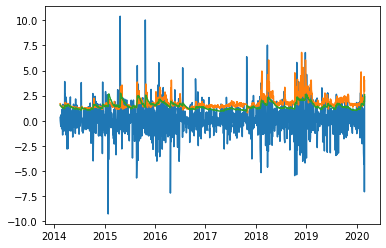

In [157]:
# Plot results
y1 = test_data['return100']
y2 = nn_predictions_df['pred']
y3 = np.sqrt(enriched_ret_data[['var_pred_GARCH-Normal-1-1']])
plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
plt.show()

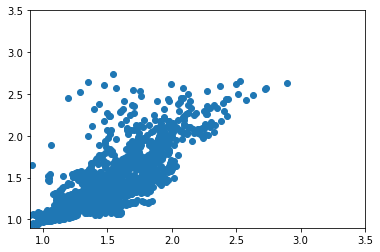

In [309]:
x = nn_predictions_df['pred']
y = np.sqrt(enriched_ret_data[['var_pred_GARCH-Normal-1-1']])
# line
axes = plt.gca()
axes.set_xlim([0.9,3.5])
axes.set_ylim([0.9,3.5])
plt.scatter(x,y)
plt.show()

In [223]:
input_data_nn = NN_obj.input
avg_change = pd.DataFrame({
    'variable': input_data_nn.columns.values,
    'llik_change_avg': ''
})

In [229]:
for var in input_data_nn.columns :
    
    print(var)
    llik_change = np.array([])
    
    for j in range(10):
        input_data_nn_temp = input_data_nn
        input_data_nn_temp[var] = np.random.permutation(input_data_nn_temp[var].values)
        
        llik_change = np.append(llik_change, NN_obj.cost(new_input = input_data_nn_temp, new_y = NN_obj.y)[0])
    print(llik_change)
    avg_llik_change = llik_change.mean()
    avg_change.loc[avg_change['variable'] == var, 'llik_change_avg'] = avg_llik_change

mean5_return100
[-11337.08043379 -11319.02431988 -11370.337689   -11337.75995128
 -11286.89207693 -11357.39690339 -11356.72367818 -11363.88817703
 -11296.75668737 -11361.21347094]
var5_return100
[-11314.37324413 -11398.42391186 -11484.83885403 -11375.44764292
 -11317.96568623 -11367.2022819  -11364.55240546 -11376.96019346
 -11371.85400714 -11396.33930331]
var_pred_EGARCH-Normal-1-1
[-11348.02862426 -11366.60412507 -11356.1891027  -11330.25223896
 -11339.79539422 -11317.53157405 -11406.9838417  -11333.99090647
 -11294.15913604 -11255.41376407]
var_pred_EGARCH-StudentsT-1-1
[-11349.2447083  -11291.11161848 -11276.41892872 -11294.53487689
 -11296.63858921 -11253.93226541 -11268.48404084 -11390.74439942
 -11362.92528676 -11340.8590957 ]
var_pred_GARCH-Normal-1-1
[-11270.73182229 -11302.56903908 -11358.29037793 -11416.57856124
 -11263.31701151 -11403.72769397 -11324.89279029 -11333.25301048
 -11230.89950787 -11382.11499881]
var_pred_GARCH-StudentsT-1-1
[-11332.45739282 -11392.54592635 -113

In [228]:
avg_change

,variable,llik_change_avg
0,mean5_return100,-11484
1,var5_return100,-11439.7
2,var_pred_EGARCH-Normal-1-1,-11450.4
3,var_pred_EGARCH-StudentsT-1-1,-11430.5
4,var_pred_GARCH-Normal-1-1,-11390
5,var_pred_GARCH-StudentsT-1-1,-11363.5


In [185]:
NN_obj.predict(new_input=NN_obj.input)

array([[2.63361672],
       [1.98689732],
       [2.13124207],
       ...,
       [3.88071167],
       [4.21106655],
       [2.98089398]])

In [186]:
NN_obj.output

array([[2.63361672],
       [1.98689732],
       [2.13124207],
       ...,
       [3.88071167],
       [4.21106655],
       [2.98089398]])